Log For Transit+RV Analysis

The Kepler Object of Interest (KOI) 6194 is a red giant harbouring a proposed transiting exoplanet (KOI-6194.01, hereafter referred to as Despoina) and a marked false positive (KOI-6194.02), both having orbital periods of ~42 and 215 days respectfully. The focus of this Jupyter Notebook is to confirm the planetary status of both candidates through transit and radial velocity (RV) modelling. Whilst the 4-year Kepler transit data is publicly available via MAST, the RV data was commissioned privately and recorded over a 4-year period by the 10m Keck telescope in Hawaii. In particular, the HIRES spectrometer observed KOI-6194 and extracted RV measurements, as well as other key parameters such as the S-index (measure of stellar activity) and surface temperature (not used in this notebook, but useful for asteroseismic analysis).

Prior to any transit analysis, a broad search for any dominant signals was performed using the RV data. Here, the unevenly spaced measurements were converted into the frequency spectrum using a lombScargle function. That is, the data was converted into a power spectrum where the power is the result of summing multiple sinusoids. This method of fourier transforming the data is far superior than conventional methods such as Box Least Squares (BLS), especially concerning transit modelling as the BLS method can underestimate the effects of stellar limb darkening. Furhtermore, the Lombscargle periodogram is designed to process unevenly sampled data, an inherent property of the RV measurements, whereas the BLS method is best-suited to samples similar to the Kepler lightcurve data. As such, the Lombscargle periodogram was used to identify the most prominent signals in the RV timeseries as a rough estimate of how many exoplanets need to be modelled. Consequently, Despoina was validated as a true exoplanet through this analysis as a strong RV signal existed at a period of ~42 days, whereas the lack of signal at a period of 215 days validated the false positive candidate KOI-6194.02 as a true false positive. Mimicking the blind search algorithm in RVSearch (a method known as 'pre-whitening'), this signal was modelled and subtracted, revealing another prominent RV signal (hereafter referred to as Arion) at a period of ~63 days. Arion's signal was then modelled, and subtracted, revealing another signal at ~400 days (hereafter refered to as Loki). However, as future results imply, Loki appears to be a rare false positive case resulting from stellar activity imprinting itself onto the RV spectrum. No furhter signal analysis was performed after this as RVsearch's periodogram implied no further signals of interest.

With the knowloedge of at most 3 exoplanets (Despoina, Arion and Loki), we can now begin the transit and RV analysis/modelling. The Kepler lightcurve data was downloaded using the python package 'lightkurve'. Since the data was taken in quarters consistent with seasons on Earth over Kepler's 4-year period, each lightcurve must be stitched together and un-physical vlaues (due to instrumental effects) must be removed as these would greatly affect modelling results. The overall lightcurve was also normalized such that the mean flux was 1.0. From the lightcurve alone it is immaediately apparent that the host star is incredibly noisy, as the spread of data is inconsistent with other main-sequence lightcurves. This is due to the star itself oscillating in modes, an optical effect that has imprinted itself onto the lightcurve. To confirm which of the 3 exopolanets are transiting and which are not, lightcurve data outside 2 days of the time of conjunction ($t_0$, midpoint of the transit/RV epoch) was cut to ease computation time, and the lightcurve was phase-folded according to the following equation: $$y = (\text{time} - t_0 + 0.5 * p_0) \% p_0 - 0.5 * p_0$$ where 'time' is the time in Barycentric Kepler Julian Date (BJKD), the time the lightcurve was taken according to Kepler and $p_0$ is the orbital period. The values for Despoina were initially taken from the NASA Exoplanet Archive but were heavily modified after performing a transit fit only, whereas Arion's and Loki's were inferred from Radvel Markov Chain Monte Carlo (MCMC) simulations. From this, it is apparent that only Despoina is a transiting exoplanet whereas Arion and Loki are RV exoplanets.

To properly model the transit and RV data they must hold time values within the same basis. That is, Kepler records data within the BKJD time basis whereas HIRES records in Julian Date (JD). To ensure consistency, the lightcurve data was converted using $$ t_{\text{JD}} = t_{\text{BKJD}} - 2454833$$
The core package at the heart of modelling both transit and RV timeseries is 'exoplanet', a gradient-inference based package that can model numerous exoplanets in transit or RV configurations simultaneously. To initialize the model, initial guesses (priors) for key parameters (such as orbital period, time of conjunction, impact parameter, planetary radius, planetary mass, stellar radius and mass) were set. Said priors were initially motivated by the Archive's recorded values, but were eventually superseded by sampled parameters (either from Radvel or Pysyd). The minimum exoplanet mass was also determined for each exoplanet as well as the RV shift. These single-valued priors and prior-widths (errors) must be assigned a corresponding distribution such that the model has an optimal parameter space to explorewhen finding the best fit model prior to MCMC sampling. The available distributions are: Normal (Gaussian), Uniform and UnitDisk. For parameters we wish to determine, a Normal prior is enforced centred at the prior with a full width at half maximum (FWHM) equal to the size of the prior-width. For parameters that hold distinct values (such as the impact parameter) or for parameters that are impossible to determine from the geometry alone (Arion's and Loki's radius and impact parameter for example), a Uniform distribution is enforced (with arbitrary priors for the latter). The Unit Disk is solely for the eccentricity of the orbits, as this can only hold values between 0 and 1 and must lie with a predefined orbit according to Kepler's Law.

There also exists unavoidable sources of noise related to the instrument and host star. These come in many forms, but the most prominent are (for instrumental) jitter; small deviations in observing caused my positioning systems, and instrumental drift; (check this). In terms of the host, the stellar variability is most demanding, requiring a completely seperate gaussian model to remove. Thus, following model initialisation these error terms are modelled and subtracted to increase the signal to noise ratio (SNR) of the lightcurve and model. Each parameter was then optimized in a psuedo-random manner rather than optimizing the entire model at once. This has made previous fits converge easier, and is encouraged (dan-foreman mackey) before optimizing the entire model. Prior to optimisation a test point prints out the current likelihood for each parameter in the model. These should all be finite values, and and NaNs or infinities result in an incorrect model which must be amended.

Following the initial fit it is best practice to check if the gaussian and transit model has correctly modelled the lightcurve. By overlaying the gaussian and transit model with the lightcurve data centred at $t_0$, it is apparent that both models correctly fit the lightcurve timeseries. Whilst the transit model indicates the presence of Despoina, there is no clear transit in either plot. This is due to the the relative noise of the timeseries; a transit is usually of the order of 1-10% of the overall flux, observing a single event is therefore statistically impossible and rather naive to discern amidst all of the scatter. A tried and true method of observing the signal is by phase folding according to the above equation, which increases the SNR of the transit (reference). So for now, take it on faith that the transit does exist and the model is infact modelling all of the events observed by Kepler, and that they are smeared by the overall luminosity of the star.

Once validating the stellar variability is correctly modelled, the gaussian model is subtracted from the lightcurve, essentially removing the stellar variability. Whilst important in asteroseismic analysis where the star is of importance, here the exoplanets are the target and hence noise caused by the host is not needed. By removing this variability it is immaediately apparent that the timeseries and hence phase folded lightcurve dratmatically increases in SNR, but there are still outliers not due to variability. These may be due to untreated instrumental effects or rare cosmological phenomena (cosmic rays) from non-local systems striking the CCD. These are promptly modelled with a 6$\sigma$ threshold, which removes data outside 6 times the standard deviation of the flux. Finally, the modified flux and timeseries are used to recalculate the models and are plotted for one final inspection. The final RV trend should be a complex sinusoid resulting from the sum of RV variations with multiple periods. Furthermore, there is an extra component due to the presence of multiple companions; the exoplanets themselves tug on each other's orbit, inducing a small contribution to the RV timeseries and must be removed. As a final validation of the model, the phase-folded transit and RV timeseries are plotted vertically. If the orbit is stable, then the midpoint of the transit should coincide with the midpoint of the RV signal, which in this case it does. This is expected as the typical time required for dynamical disruption is of the order of millions of years (reference), and is already implied to be stable by the presence of multiple transit signals. Furthermore, Transit Timing Variations (TTVs), where exoplanets in resonance can incur slight defects in orbital period, is a valid concern towards dynamical stability as planet-planet scattering is a theorised evolutionary path. However, in this analysis this possibility is ignored as no variability in the transit lightcurve is apparent.

Finally, the current best fitting model is passed through the the MCMC sampler provided by PyMC3. We sampled for 1,500 tunes and 1,000 draws, over 2 CPUs and chains, resulting a total number of 7,000 iterations with a 95% acceptance threshold. It should be noted that multicore sampling is essential for exoplanet and PyMC3 to determine correlations between parameters. Annoyingly, multicore sampling is not possible on Windows or Mac operating systems, and can be done hassle free in Linux. As such, this notebook takes place within the Windows Subsystem for Linux (WSL), where multicore sampling magically works. Whilst worrisome at first; the MCMC projected a 2 hour fitting time, the chains mixed very quickly resulting in a very fast convergence and hence overall sampling rate of 25 minutes. To validate the convergence however key statistics produced during the MCMC fit were investigated, primarily the Gelban-Ruben (GR) and ess values. Indicative of a good fit, each GR should be less that 1.01 and ess be as high as possible (reference). Since these were achieved for all parameters, the fit can be further investigated through the corner plots. These should the parameters space the MCMC spanned, ideally with a region of concentric rings and a convergence point. These are known as Probability Distribution Functions (PDF), and for every gaussian prior there should be a gaussian PDF and for unknown priors (i.e. certain radius and impact parameters) there should be uniform distributions. These simply mean that for the model provided the best fitting parameter that is highly likely to explain the observed trend (i.e. transit and RV signal) lies in the centre of the gaussian PDF; the highest likelihood/point in the PDF. For others that have no bearing on the transit signal they should return an equally likely PDF spanning the entire parameter space. These are certainly observed, so the MCMC fit can be concluded as a success.

Finally, the mean  and standard deviation of the PDFs is taken, and the final transit and RV timeseries is plotted, detailing the key parameters such as period, impact parameter, radius, minimum mass and eccentricity.

In [1]:
import pandas as pd, numpy as np, lightkurve as lk
from astropy.io import fits
import matplotlib.pyplot as plt, exoplanet as xo
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from scipy import signal
from sinusoid import SinusoidModel
from astropy.timeseries import LombScargle
from astropy.table import Table

#import data file
lcfs = lk.search_lightcurve("KIC 9145861", author="Kepler").download_all()

lc = lcfs.stitch().remove_nans().remove_outliers().normalize() # type: ignore

time = np.ascontiguousarray(lc.time.value, dtype=np.float64)
flux = np.ascontiguousarray(lc.flux, dtype=np.float64)
flux_err = np.ascontiguousarray(lc.flux_err,dtype=np.float64)
texp = 29.7 / (60 * 24) # exposure time in days
#time=0 in BJD_TDB
BJD = time+2454833

#RV Data
dat = pd.read_csv('k06194_rv_mod.csv')
dat.dropna(inplace=True)
rv = np.ascontiguousarray(dat.mnvel, dtype=np.float64) # rv in m/s
rv_err = np.ascontiguousarray(dat.errvel, dtype=np.float64) # rv errors in m/s
t = np.ascontiguousarray(dat.bjd,dtype=np.float64) # time in BJD
s = np.ascontiguousarray(dat.svalue,dtype=np.float64)
t_BKJD = t - 2454833 # converting BJD into BKJD
inst_names = ["hires"]
num_inst = len(inst_names)

In [2]:
print(np.std(flux))

0.00032210632449517336


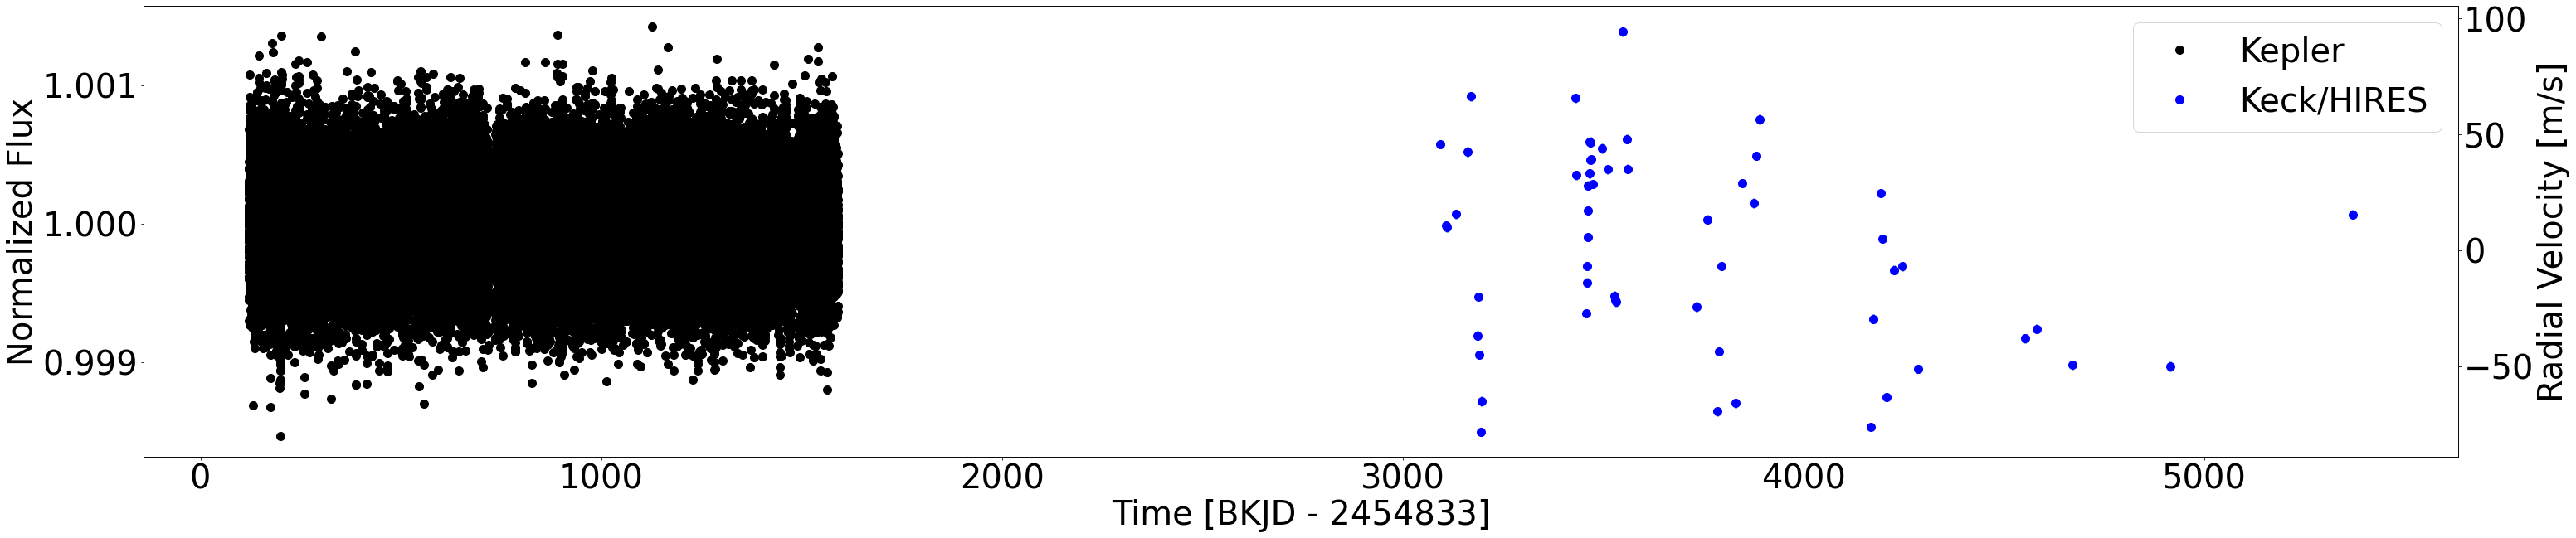

In [3]:
fig_data, axes = plt.subplots(1,figsize=(50, 10))

font = 40
ax2 = axes.twinx()
p1, = axes.plot(time,flux, ".k",markersize=20.0,label='Kepler')
axes.set_ylabel('Normalized Flux',fontsize=font)
axes.set_xlabel('Time [BKJD - 2454833]',fontsize=font)

p2, = ax2.plot(t_BKJD, rv,'.b',markersize=20.0,label='Keck/HIRES',zorder=100)
ax2.errorbar(t_BKJD, rv, yerr=rv_err,fmt='None',elinewidth=3.0)
ax2.set_ylabel("Radial Velocity [m/s]",fontsize=font)
axes.tick_params(axis='both', which='major', labelsize=font)
ax2.tick_params(axis='both', which='major', labelsize=font)

lines = [p1,p2]
_ = axes.legend(lines, [l.get_label() for l in lines],fontsize=font)
fig_data.savefig('Data.png',facecolor='w',dpi=100, bbox_inches='tight')

Functions

In [4]:
def Annotate(txt, x,y,fontsize):
    ax.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(x,y),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=fontsize,
    bbox=dict(facecolor='white')
    )      

Pre-whitening Algorithm

370.3703703703703


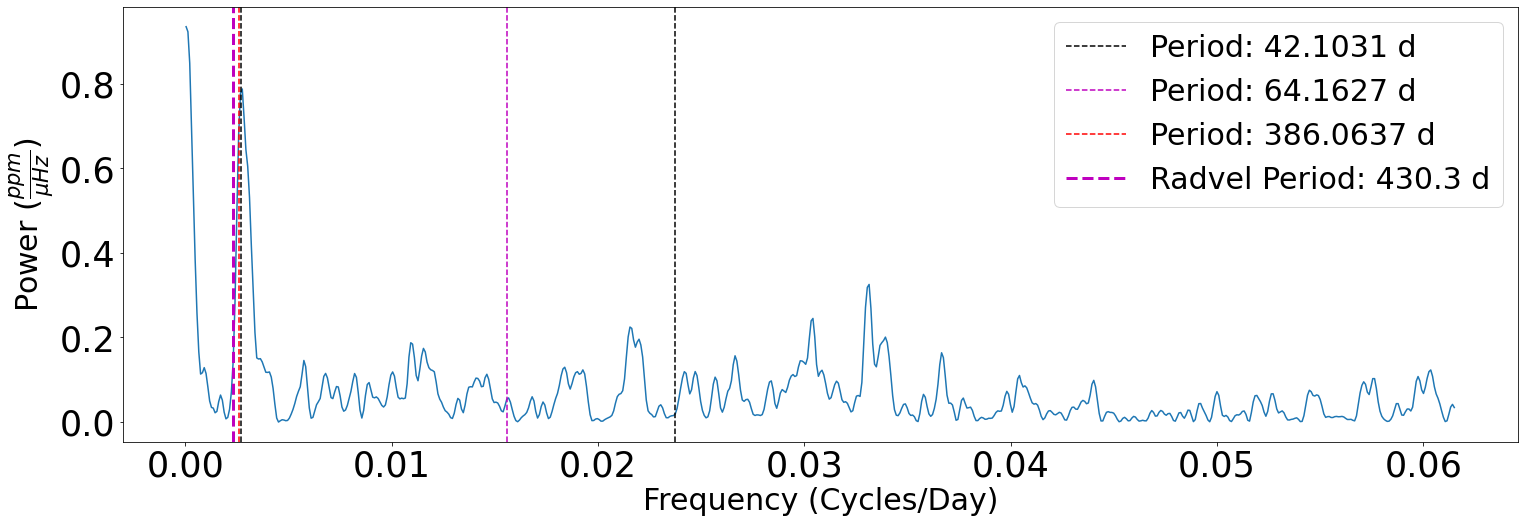

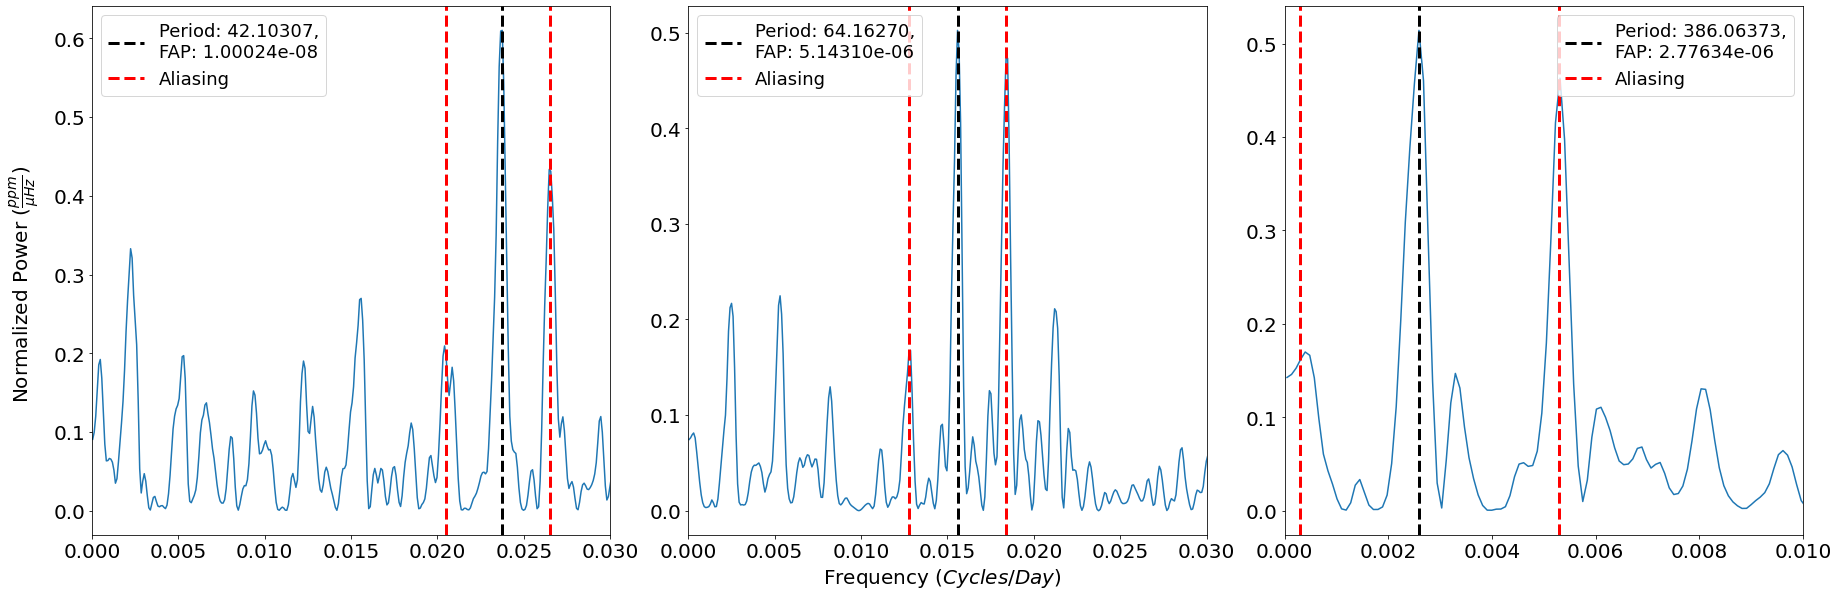

In [5]:
#done in more detail in s-value.ipynb
#frequency limits
f_max = 1/10 #cycles/day, corresponding to a period of 10 days
f_min = 1/1000 #cycles/day, corresponding to a period of 1000 days
frequency = np.linspace(f_min,f_max,num=600)

#Note, when calculating periodogram convert frequencies to angular frequencies
ls_b = LombScargle(t,rv, normalization='standard',fit_mean=True)
freq_b, power_b = ls_b.autopower(method='slow')
planet_b_freq = freq_b[np.argmax(power_b)]

simple_b = SinusoidModel()
simple_b.frequencies = [planet_b_freq]
simple_b.modes = [[1],[2],[3]]
#fitting model to data
simple_b.fit_to_data(t,rv)
#overplotting data on first fit
fit_magnitudes = simple_b(t)
#removing model from data
residual = rv - simple_b(t)

#periodogram for planet c
ls_c = LombScargle(t,residual, normalization='standard',fit_mean=True)
freq_c, power_c = ls_c.autopower(method='slow')
planet_c_freq = freq_c[np.argmax(power_c)]

#specifying model
simple_c = SinusoidModel()
simple_c.frequencies = [planet_c_freq]
simple_c.modes = [[1],[2],[3]]
#fitting model to data
simple_c.fit_to_data(t,rv)
#overplotting data on first fit
fit_magnitudes_c = simple_c(t)
#removing model from data
residual_c = residual - simple_c(t)

#periodogram for planet d
ls_d = LombScargle(t,residual_c, normalization='standard',fit_mean=True)
freq_d, power_d = ls_d.autopower(method='slow')
planet_d_freq = freq_d[np.argmax(power_d)]
#specifying model
simple_d = SinusoidModel()
simple_d.frequencies = [planet_d_freq]
simple_d.modes = [[1],[2],[3]]
#fitting model to data
simple_d.fit_to_data(t,rv)
#overplotting data on first fit
fit_magnitudes_d = simple_d(t)

false_b = ls_b.false_alarm_probability(power_b.max(),method="baluev")
false_c = ls_c.false_alarm_probability(power_c.max(),method="baluev")
false_d = ls_d.false_alarm_probability(power_d.max(),method="baluev")

ls_s = LombScargle(t,s, normalization='standard',fit_mean=False,center_data=False)
freq_s, power_s = ls_s.autopower(method='slow')
max_freq = freq_s[np.argmax(power_s)]

fig, axes = plt.subplots(figsize=(25,8),sharex=False)

labelsize = 20
fontsize=18

ax = axes
ax.plot(freq_s,power_s)
ax.axvline(planet_b_freq, color='k',label='Period: {:.4f} d'.format(1/planet_b_freq), linestyle='--')
ax.axvline(0.0027, color='k',linestyle='--')
print(1/0.0027)
ax.axvline(planet_c_freq, color='m',label='Period: {:.4f} d'.format(1/planet_c_freq), linestyle='--')
ax.axvline(planet_d_freq, color='r',label='Period: {:.4f} d'.format(1/planet_d_freq), linestyle='--')
ax.axvline(1/430.3, c='m',linestyle='--',linewidth=3.0,label='Radvel Period: 430.3 d')
ax.tick_params(axis='both', which='major', labelsize=35)
ax.set_xlabel('Frequency (Cycles/Day)',fontsize=30)
ax.legend(loc='upper right',fontsize=30)
ax.set_ylabel(r'Power $(\frac{ppm}{\mu Hz}$)',fontsize=30)
fig.savefig('S-index.png',dpi=100,facecolor='w',bbox_inches='tight')

fig_whiten, axes = plt.subplots(1,3, figsize=(25,8),sharex=False)
ax = axes[0]
ax.plot(freq_b,power_b)
ax.axvline(planet_b_freq, color='black',linewidth=3.0,label='Period: {0:.5f},\nFAP: {1:.5e}'.format(1/planet_b_freq,false_b), linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.axvline(0.0205, c='r',linestyle='--',linewidth=3.0,label='Aliasing')
ax.axvline(0.0265, c='r',linestyle='--',linewidth=3.0)
ax.legend(loc='upper left',fontsize=fontsize)
ax.set_xlim(0,0.03)

ax = axes[1]
ax.plot(freq_c,power_c)
ax.axvline(planet_c_freq, color='black',linewidth=3.0,label='Period: {0:.5f},\nFAP: {1:.5e}'.format(1/planet_c_freq,false_c), linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.axvline(0.0128, c='r',linestyle='--',linewidth=3.0,label='Aliasing')
ax.axvline(0.0184, c='r',linestyle='--',linewidth=3.0)
ax.legend(loc='upper left',fontsize=fontsize)
ax.set_xlim(0,0.03)

ax = axes[2]
ax.plot(freq_d,power_d)
ax.axvline(planet_d_freq, color='black',linewidth=3.0,label='Period: {0:.5f},\nFAP: {1:.5e}'.format(1/planet_d_freq,false_d), linestyle='--')
ax.axvline(0.0003, c='r',linestyle='--',linewidth=3.0,label='Aliasing')
ax.axvline(0.0053, c='r',linestyle='--',linewidth=3.0)
ax.legend(loc='upper right',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_xlim(0,0.01)

fig_whiten.text(0.5, -0.01, r'Frequency $(Cycles/Day)$', ha='center', va='center', fontsize=labelsize)
fig_whiten.text(-0.01, 0.5, r'Normalized Power $(\frac{ppm}{\mu Hz}$)', ha='center', va='center', rotation='vertical',fontsize=labelsize)
plt.tight_layout()
fig_whiten.savefig('Pre-whitening.png',dpi=100,facecolor='w',bbox_inches='tight')
# fig.savefig('RV_Freq_spectrum.png',dpi=100,facecolor='w')
# fig.savefig('spectrum_comparisons.png', facecolor='w')

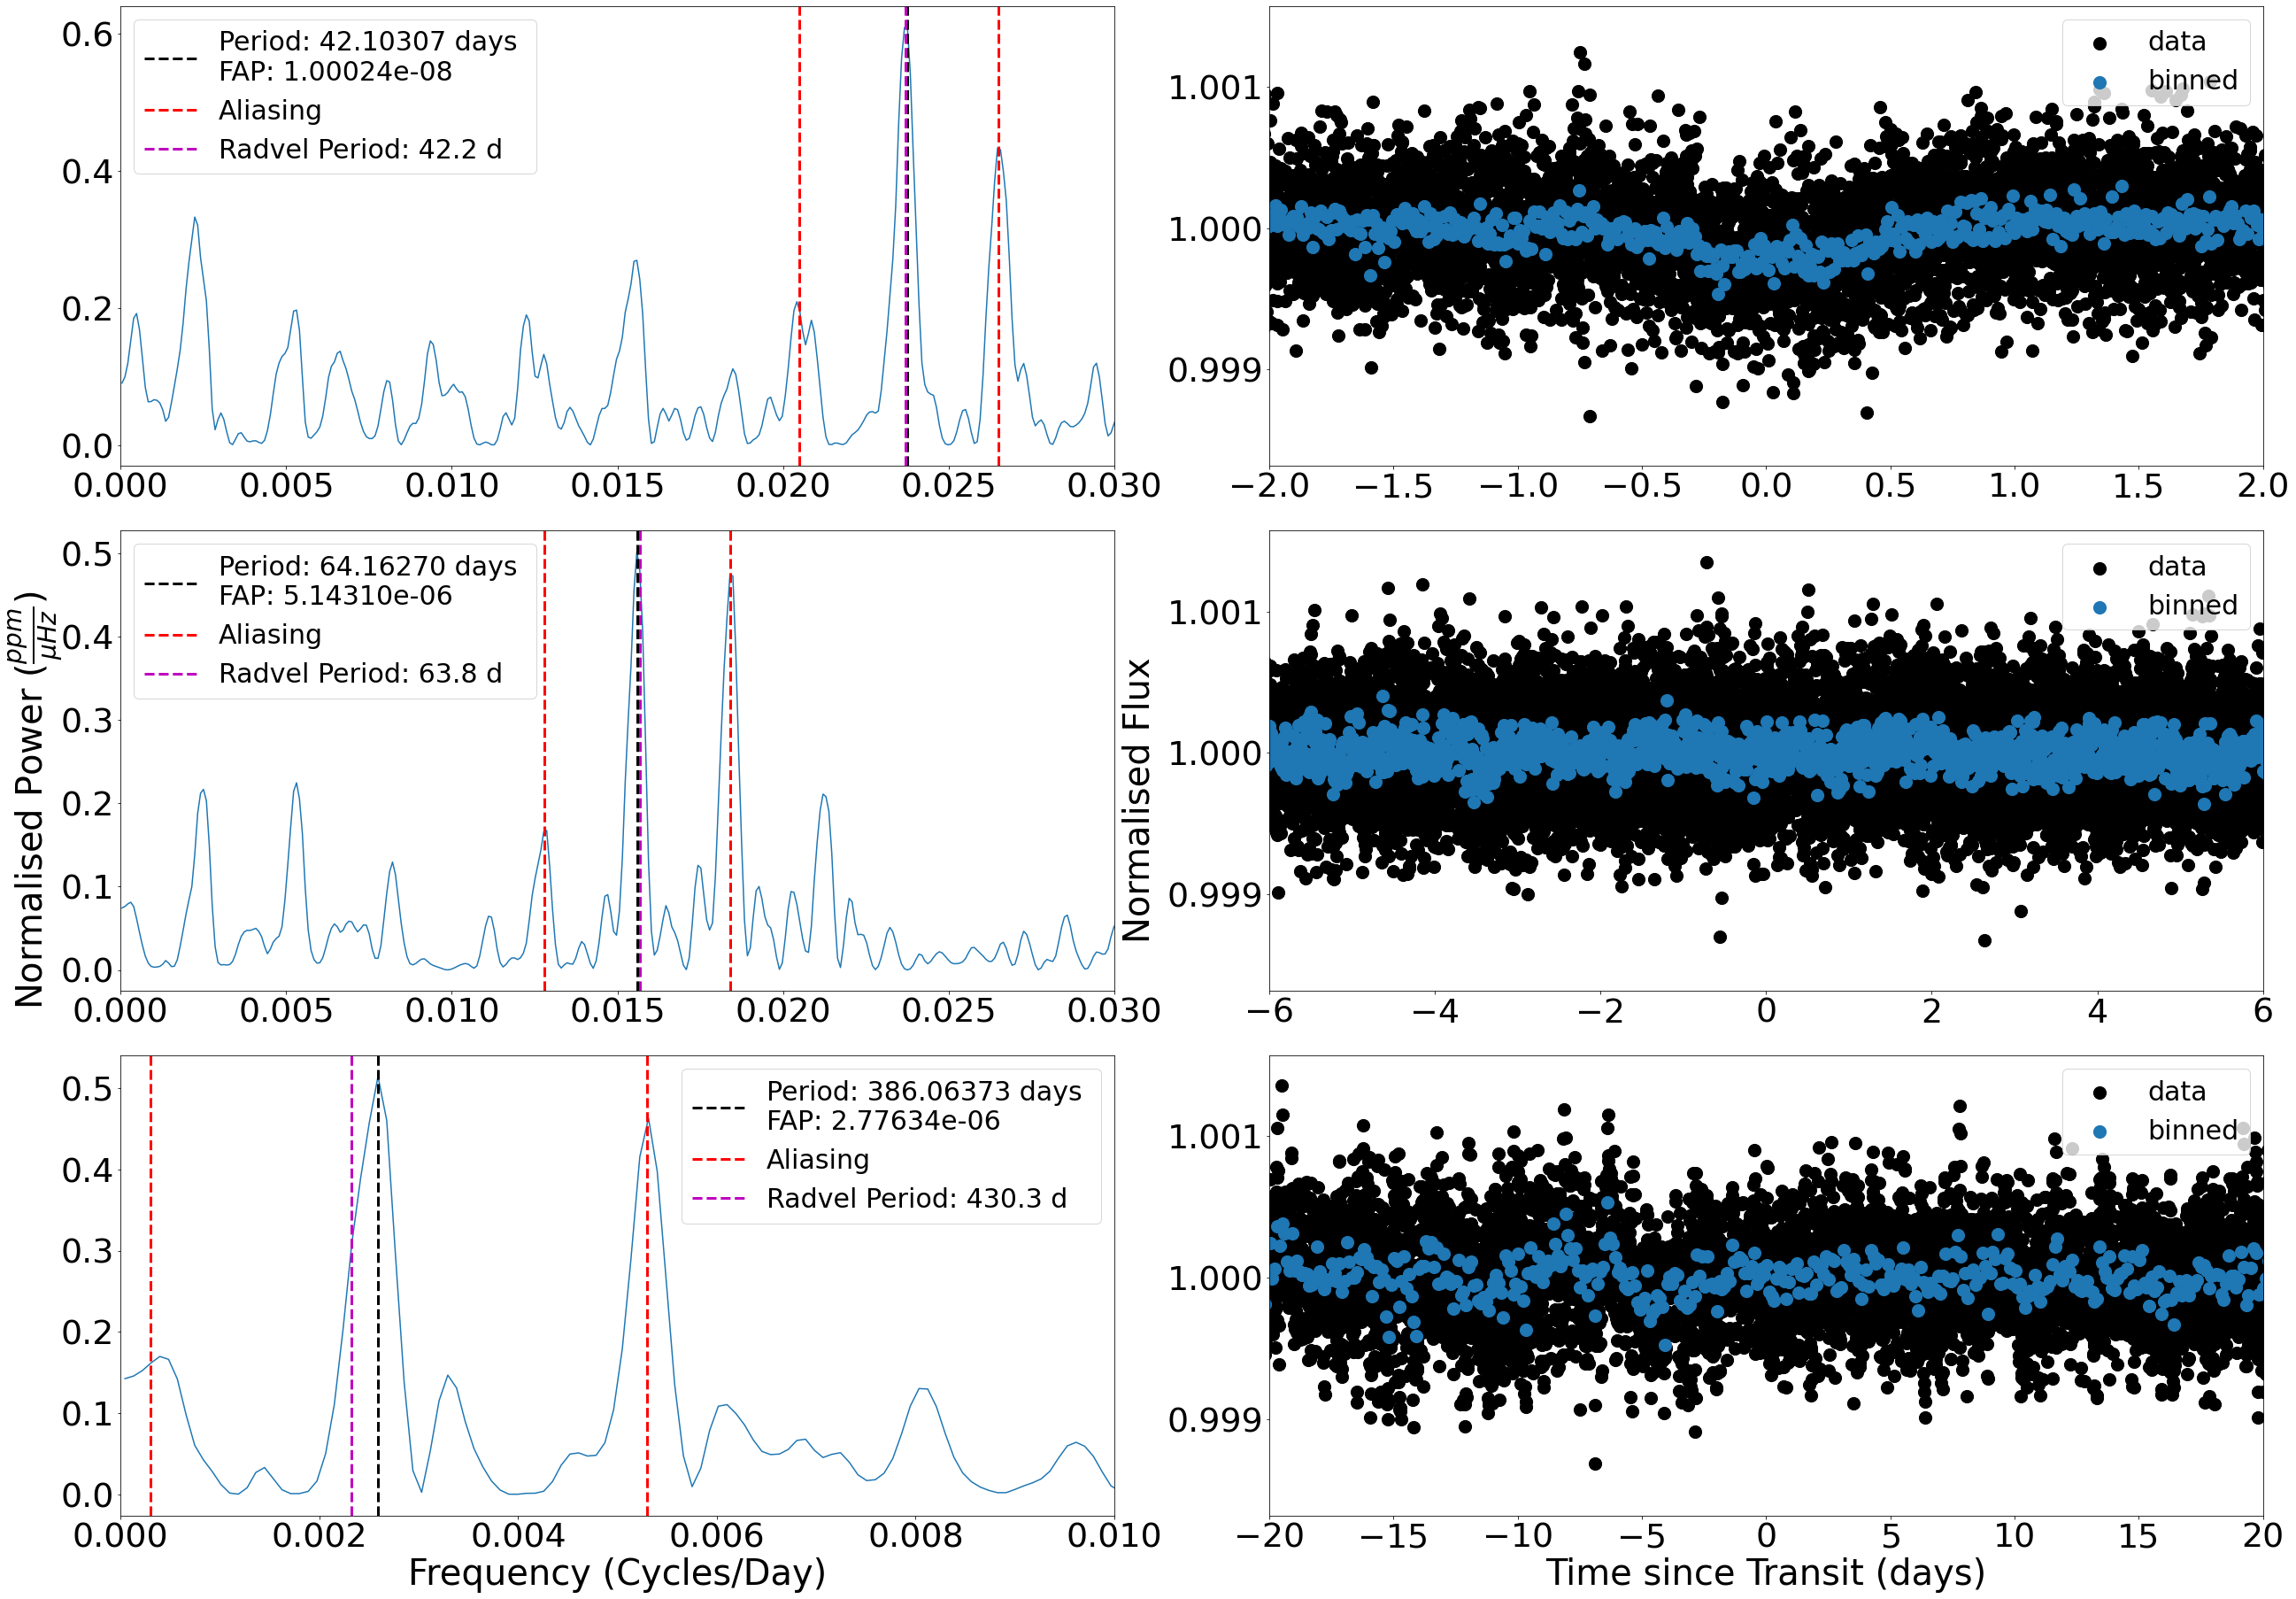

In [6]:
from scipy import signal
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from sinusoid import SinusoidModel
#RV Data
dat = pd.read_csv('k06194_rv_mod.csv')
rv = np.array(dat.mnvel) # rv in m/s
rv_err = np.array(dat.errvel) # rv errors in m/s
t = np.array(dat.bjd) # time in BJD
t_BKJD = t - 2454833 # converting BJD into BKJD
inst_names = ["hires"]
num_inst = len(inst_names)

fontsize=30
titlesize=40
labelsize=38

fig, axes = plt.subplots(3,2, figsize=(35,25),sharex=False)
ax = axes[0,0]
ax.plot(freq_b,power_b)
ax.axvline(planet_b_freq, color='black',label='Period: {0:.5f} days \nFAP: {1:.5e}'.format(1/planet_b_freq,false_b), linestyle='--',linewidth=3.0)
ax.axvline(0.0205, c='r',linestyle='--',linewidth=3.0,label='Aliasing')
ax.axvline(0.0265, c='r',linestyle='--',linewidth=3.0)
ax.axvline(1/42.2, c='m',linestyle='--',linewidth=3.0,label='Radvel Period: 42.2 d')
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.legend(loc='upper left', fontsize=fontsize)
ax.set_xlim(0,0.03)

ax = axes[1,0]
ax.plot(freq_c,power_c)
ax.axvline(planet_c_freq, color='black',label='Period: {0:.5f} days \nFAP: {1:.5e}'.format(1/planet_c_freq,false_c), linestyle='--',linewidth=3.0)
ax.axvline(0.0128, c='r',linestyle='--',linewidth=3.0,label='Aliasing')
ax.axvline(0.0184, c='r',linestyle='--',linewidth=3.0)
ax.axvline(1/63.8, c='m',linestyle='--',linewidth=3.0,label='Radvel Period: 63.8 d')
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.legend(loc='upper left', fontsize=fontsize)
ax.set_xlim(0,0.03)

ax = axes[2,0]
ax.plot(freq_d,power_d)
ax.axvline(planet_d_freq, color='black',label='Period: {0:.5f} days \nFAP: {1:.5e}'.format(1/planet_d_freq,false_d), linestyle='--',linewidth=3.0)
ax.axvline(0.0003, c='r',linestyle='--',linewidth=3.0,label='Aliasing')
ax.axvline(0.0053, c='r',linestyle='--',linewidth=3.0)
ax.axvline(1/430.3, c='m',linestyle='--',linewidth=3.0,label='Radvel Period: 430.3 d')
ax.set_xlabel('Frequency (Cycles/Day)',fontsize=titlesize)
ax.legend(loc='upper right', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_xlim(0,0.01)

ax = axes[0,1]
t0s_b = 2458350.5 - 2454833 # from radvel converted to BKJD
periods = 42.2960# from Transit fit
p0_b = 1/planet_b_freq
x_fold_b = (time - t0s_b + 0.5 * periods) % periods - 0.5 * periods

binned = lc.fold(period=periods, epoch_time=t0s_b).bin(.008).remove_outliers()
flux_binned = binned.flux
time_binned = binned.time.value
flux_err_binned = binned.flux_err

ax.scatter(x_fold_b,flux,c="k",s=200, label='data',zorder=-1000) 
ax.scatter(time_binned,flux_binned,s=200, label='binned', zorder=2) 
ax.legend(loc='upper right',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_xlim(-2,2)

# plot data within 2 days of transit
days =  2
transit_mask = (
    np.abs(
        (time - t0s_b + 0.5 * periods) % periods - 0.5 * periods
    )
    < days
)
time_cull = time[transit_mask]
flux_cull = flux[transit_mask]
flux_err_cull = flux_err[transit_mask]
x_fold_cull = (time_cull - t0s_b + 0.5 * periods) % periods - 0.5 * periods

ax = axes[1,1]
t0_c = 2458213.9 - 2454833 # t_conj from Radvel, converted to BKJD
p0_c = 1/planet_c_freq
x_fold_c = (time - t0_c + 0.5 * p0_c) % p0_c - 0.5 * p0_c
binned_c = lc.fold(period=p0_c, epoch_time=t0_c).bin(.008).remove_outliers()
flux_binned_c = binned_c.flux
time_binned_c = binned_c.time.value
flux_err_binned_c = binned_c.flux_err

ax.scatter(x_fold_c,flux,c="k",s=200, label='data',zorder=-1000)
ax.scatter(time_binned_c,flux_binned_c,s=200, label='binned', zorder=2) 
ax.legend(fontsize=fontsize,loc='upper right')
ax.set_xlim(-6,6)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

ax = axes[2,1]
t0_d = 2458446.0 - 2454833 # t_conj from Radvel, converted to BKJD
p0_d = 1/planet_d_freq #1/planet_d_freq
x_fold_d = (time - t0_d + 0.5 * p0_d) % p0_d - 0.5 * p0_d
binned_d = lc.fold(period=p0_d, epoch_time=t0_d).bin(.1).remove_outliers()
flux_binned_d = binned_d.flux
time_binned_d = binned_d.time.value
flux_err_binned_d = binned_d.flux_err

ax.scatter(x_fold_d,flux,c="k",s=200, label='data',zorder=-1000)
ax.scatter(time_binned_d,flux_binned_d,s=200, label='binned', zorder=2) 
ax.legend(fontsize=fontsize,loc='upper right')
ax.set_xlim(-20,20)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_xlabel('Time since Transit (days)',fontsize=titlesize)

fig.text(-0.01, 0.5, r'Normalised Power ($\frac{ppm}{\mu Hz}$)', ha='center', va='center', rotation='vertical',fontsize=titlesize)
fig.text(0.485, 0.5, 'Normalised Flux', ha='center', va='center', rotation='vertical',fontsize=titlesize)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3)
plt.savefig('Planetary Classification.png', facecolor='w',dpi=100,bbox_inches='tight')

Priors for exoplanet

Note that transit priors will be heavily constrained as they are well known from a prior transit-only fit

In [7]:
import astropy.units as u
from IPython.display import display, Math
# Priors sourced from "KOI-6194 Candidate Records, Exoplanet Archive"
M_J = 317.93842034806 # Mass of Jupiter
# Mass priors from Radvel
M_b = 0.87 * M_J # Mass of first planet
M_c = 0.93 * M_J # Mass of second planet
M_d = 1.34 * M_J # Mass of third planet
M_p = np.array([M_b, M_c,M_d]) #mass of planets in earth mass 
M_p_err = np.array([0.2, 0.5, 0.13]) # mass of planet errors 0.2
t0_radvel = np.array([2458350.5,2458213.9,2458446.0]) # time of conjunction in JD from Radvel
t0s_c = t0_radvel[1]-2454833
t0s_d = t0_radvel[2]-2454833
t0s = np.array([3517.58230672,t0s_c,t0s_d]) # Phase/midpoint reference in KBJD - Transit phase well known
t0s_err = np.array([0.6,1.1,7.5]) 
periods = np.array([42.29, 63.53, 423.0]) # 42.29602169period in days, both from Transit fit and Radvel - Transit period well known 
periods_errs = np.array([0.0001, 6.3, 42.3]) #period errors
u_star = np.array([0.5890,0.1473]) #Limb Darkening Coeff. (u \in [0,1]) 
R_p = np.array([9.4798,5, 15]) # radius of planet (Earth R), 2nd and 3rd radius assumed - should return these priors in uniform distribution
R_p_err =  np.array([1.8497, 5, 5])

# parameters from asteroseismology
astero = pd.read_csv('Pysyd_results.csv')
Dnu_py = np.array([astero['value'][5], astero['uncertainty'][5]]) 
numax_py = np.array([astero['value'][2], astero['uncertainty'][2]])
MH = [0.36,0.06]

# these are from the HIRES spectrograph pipeline
Teff_HIRES = np.array([4725.29,100])
#from lightkurve documentation
nu_maxsolar = 3090
Dnu_solar = 135.1
T_eff_solar = 5777.2

def f_Dnu(Dnu,numax,Teff,mh):
    fdnu =  4.015+0.168*np.log10(numax/3090)-0.186*np.log10(Dnu/135.1) - \
        10.234*(Teff/5777.2)+11.432*(Teff/5777.2)**2-4.2*(Teff/5777.2)**3+0.001*mh
    return fdnu

f_dnu = f_Dnu(Dnu_py[0],numax_py[0],Teff_HIRES[0],MH[0])
print(f_dnu)

def MassRelation(Dnu, numax,T,f_dnu):
    return (numax/nu_maxsolar)**3 * (Dnu/(f_dnu*Dnu_solar))**(-4) * (T/T_eff_solar)**(3/2)

def MassUnc(Dnu,Dnu_err,numax,numax_err,T,T_err):
    return MassRelation(Dnu,numax,T,f_dnu) * np.sqrt((3* Dnu_err/Dnu)**2 + (4 * numax_err/numax)**2 + ((3/2) * T_err/T)**2)

def RadRelation(Dnu, numax,T,f_dnu):
    return (numax/nu_maxsolar) * (Dnu/(f_dnu*Dnu_solar))**(-2) * (T/T_eff_solar)**(1/2)

def RadUnc(Dnu,Dnu_err,numax,numax_err,T,T_err):
    return RadRelation(Dnu,numax,T,f_dnu) * np.sqrt(( Dnu_err/Dnu)**2 + (2 * numax_err/numax)**2  + ((1/2) * T_err/T)**2)

def DensityRel(Dnu,f_dnu):
    return ((Dnu/(f_dnu*Dnu_solar))**2) * (1.4)

def DensUnc(Dnu,Dnu_err):
    return DensityRel(Dnu,f_dnu) * np.sqrt((2*Dnu_err/Dnu)**2)

def GravRelation(numax,T):
    return ((numax/nu_maxsolar) * np.sqrt(T/T_eff_solar)) * 28.02

def GravUnc(numax,numax_err,T,T_err):
    return GravRelation(numax,T) * np.sqrt((numax_err/numax)**2 + ((1/2) * T_err/T)**2)

rho = DensityRel(Dnu_py[0],f_dnu)
Drho = DensUnc(Dnu_py[0],Dnu_py[1])
Rho_s_dnu = np.array([rho ,Drho]) #using the scaling relation Delta nu \propto \sqrt(\rho_*) 

M_s = np.array([MassRelation(Dnu_py[0],numax_py[0],Teff_HIRES[0],f_dnu), #star mass (solar M)
                MassUnc(Dnu_py[0],Dnu_py[1],numax_py[0],numax_py[1],Teff_HIRES[0],Teff_HIRES[1])])
R_s = np.array([RadRelation(Dnu_py[0],numax_py[0],Teff_HIRES[0],f_dnu), #star radius (solar R)
                RadUnc(Dnu_py[0],Dnu_py[1],numax_py[0],numax_py[1],Teff_HIRES[0],Teff_HIRES[1])])
g_s = np.array([np.log10(GravRelation(numax_py[0],Teff_HIRES[0])*980.665), 
                np.log10(GravUnc(numax_py[0],numax_py[1],Teff_HIRES[0],Teff_HIRES[1])*980.665)])

M_result = r"M_* = ({0:.4f}  \pm {2:.4f}) M_{1}".format(M_s[0],r"\odot",M_s[1])
R_result = r"R_* = ({0:.4f} \pm {2:.4f}) R_{1}".format(R_s[0],r"\odot",R_s[1])
g_result = r"g_* = ({0:.4f} \pm {2:.4f}) {1}".format(g_s[0],r'(dex)', g_s[1])

rho_result = r"\rho_* = ({0:.4e} \pm {2:.4e}) \rho_{1}".format(Rho_s_dnu[0],r"{cgs}",Rho_s_dnu[1])
display(Math(M_result), Math(R_result), Math(rho_result), Math(g_result))

R_s_lightkurve = np.array([6.19, 0.6]) 
M_s_lightkurve = np.array([1.53, 0.1]) 

ecc_planet = np.array([0.149,0.2, 0.045]) # eccentricity of planets from Radvel
ecc_err = np.array([0.04,0.05, 0.05]) # eccentricity errors
omega_planet = np.array([-0.56, 2.7, 0.5]) # argument of periasteron from Radvel
omega_planet_err = np.array([0.35, 0.22,1.5]) # argument errors

Ks = xo.estimate_semi_amplitude(periods, t_BKJD, rv, t0s=t0s) # type:ignore
msini = xo.estimate_minimum_mass(periods, t_BKJD, rv, rv_err, t0s=t0s, m_star=M_s[0]) # type: ignore
msini = msini.to(u.M_earth) # type: ignore


0.9683952366765148


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Combined Transit and RV Model

In [8]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
t_rv = np.linspace(t_BKJD.min() - 5, t_BKJD.max() + 5, 2000) # fine grid to calculate RVs over
x_rv_ref = 0.5 * (t_BKJD.min() + t_BKJD.max()) # midpoint of RV timeseries
phase_lc = np.linspace(-0.3, 0.3, 100)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(time_cull), dtype=bool)
    with pm.Model() as model: # type: ignore
        # sampled stellar parameters
        mean = pm.Normal("mean", mu=1, sd=10) # The baseline flux

        #Constraining well-known transit priors
        t0 = pm.Normal("t0", mu=t0s,shape=3, sd=0.0001) # The time of a reference transit for each planet sd=t0s[1],
        log_period = pm.Normal("log_period", mu=tt.log(periods), sd=0.0001,shape=3) # The log period ,sd = periods_errs
        period = pm.Deterministic("period", tt.exp(log_period)) # tracking the period

        log_m_pl = pm.Normal("log_m_pl", mu=tt.log(msini.value),sd=2,shape=3) # sample planet mass
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl)) # track planet mass
        u_ql = xo.distributions.QuadLimbDark("u",initval=u_star) # informing exoplanet of quad. Limb Dark.,
        star = xo.LimbDarkLightCurve(u_ql)
        m_star = pm.Normal("m_star", mu=M_s[0], sd=M_s[1]) # sample mass of star
        rho_star = pm.Normal("rho_star",mu=Rho_s_dnu[0],sd=Rho_s_dnu[1]) # sample stellar density
        r_star = pm.Deterministic("r_star", (m_star/rho_star)**(1/3)) # type: ignore
        b = pm.Uniform("b", upper=1, lower=0,shape=3) # uniform prior on impact parameter since 2 are unknown --> RV planets
        r_pl = pm.Uniform("r_pl", upper=50,lower=1,initval=R_p, shape=3) # uniform prior on radii since 2 are unknown --> RV planets
        r_stellar =  (r_pl * 6378/696000) # type: ignore , convert to solar radii - used later in lightcurve model
        ror = pm.Deterministic("ror", r_stellar/r_star) # track ratio of radii (shoud be solar radii/solar radii)
        
        # Eccentricity & argument of periasteron
        ecs = pmx.UnitDisk("ecs", shape=(2,3),initval=0.01 * np.ones((2,3))) # should be shape=(2,n) where n= # of planets
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2,axis=0)) # type: ignore , bound within [0,1]
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1],ecs[0])) # type: ignore

        # RV jitter & a quadratic RV trend
        jitter = pm.Normal("jitter", mu=tt.log(6.58)) # jitter from Radvel
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3) # trend of RV measurements

        # Transit jitter
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(flux_cull[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal( # mean amplitude of data
            "log_sigma_gp", mu=tt.log(np.std(flux_cull[mask])), sd=10
        )
        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(flux_err_cull[mask])), sigma=2.0)
        
        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(
            rho_star=rho_star, 
            m_star=m_star,
            period=period,
            t0=t0, 
            b=b, 
            m_planet=xo.units.with_unit(m_pl, msini.unit), # type: ignore 
            ecc=ecc, 
            omega=omega
            )
        
        # track the semi-major axis
        a = pm.Deterministic("a", orbit.a)
        # RV drift of HIREs
        means = pm.Normal(
            "means",
            mu=np.array([np.median(rv)]),
            sigma=200,
            shape=num_inst,
        )
        # Compute the RV offset for each data point
        mean_rv = tt.zeros(len(t_BKJD))
        mean_rv += means # type: ignore
        pm.Deterministic("mean_rv", mean_rv) # track this offset for plotting purposes
        K = pm.Deterministic("K",orbit.K0*(m_pl/M_J)) #<--check this

        # Compute the model light curve, noting that r is in solar radii
        light_curves = star.get_light_curve(orbit=orbit, r=r_stellar, t=time_cull)
        light_curve = pm.math.sum(light_curves, axis=-1) + mean # accounts for relative flux offset # type: ignore
        resid = flux_cull[mask] - light_curve[mask]

        # GP model for the light curve
        kernel = terms.SHOTerm(sigma=tt.exp(log_sigma_gp),rho=tt.exp(log_rho_gp), Q=1/np.sqrt(2)) # type: ignore
        # model RV variability, periodicity is measured here for rho
        gp = GaussianProcess(kernel=kernel, t=time_cull[mask],diag=flux_err_cull[mask]**2 + tt.exp(2 * log_jitter),mean=mean) # diag=flux_err_cull[mask]**2 + tt.exp(2 * log_jitter),mean=meantime scale ,yerr=tt.exp(log_sigma_lc)
        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=resid)
        pm.Deterministic("light_curves", light_curves) # Track the value of model light curve for plotting and chi^2 optimization purposes
        pm.Normal("obs_lc", mu=light_curve, sd=flux_err_cull, observed=flux_cull) # The likelihood function of the lightcurve model

        #include RVs in most probable model
        def get_rv_model(x, name=""):
                # First the RVs induced by the planets
                vrad = orbit.get_radial_velocity(x)
                pm.Deterministic("vrad" + name, vrad)
                # Define the background model
                A = np.vander(x - x_rv_ref, 3)
                bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))
                # Sum over planets and add the background to get the full model for 1 planet, put tt.sum(vrad, axis=-1) in for multiple planets
                return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1)  + bkg) 
        
        # Define the RVs at the observed times
        rv_model = get_rv_model(t_BKJD)
        # Also define the model on a fine grid as computed above (for plotting)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(rv_err**2 + tt.exp(2 * jitter)) # type: ignore , adding RV errors in quadrature
        pm.Normal("obs_rv", mu=rv_model, sd=err, observed=rv) # track RV model for chi^2 optimization purposes

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",tt.stack([star.get_light_curve(orbit=orbit, r=r_stellar, t=time_cull)],axis=-1))

        # Checking MAP model; are Nans present? Is logp = inf? If so reparameterize
        print(model.check_test_point())
        start = model.test_point

        # optimizing with m_star+rho_star
        gp_lc_params = [log_sigma_lc, log_sigma_gp, log_rho_gp,log_jitter]
        transit_params = [r_pl,t0,log_period,b,m_pl]
        stellar_params = [r_star]
        rv_params = [m_pl,ecs,mean_rv,jitter]
        map_soln = pmx.optimize(start=start, vars=gp_lc_params)
        map_soln = pmx.optimize(start=map_soln, vars=transit_params)
        map_soln = pmx.optimize(start=map_soln, vars=rv_params)
        map_soln = pmx.optimize(start=map_soln)

        extra_names = ["light_curves", "gp_pred"]
        extra_paras = [light_curves, gp.predict(resid)]

        extras = dict(
                zip(
                    extra_names,
                    pmx.eval_in_model(extra_paras, map_soln),
                )
        )
        txt, bib = xo.citations.get_citations_for_model()
    return model, map_soln, extras, orbit, txt, bib
model0, map_soln0, extras0, orbit0, txt, bib= build_model() 


mean                      -3.220000e+00
t0                         2.487000e+01
log_period                 2.487000e+01
log_m_pl                  -4.840000e+00
u_quadlimbdark__          -2.820000e+00
m_star                     2.160000e+00
rho_star                   9.850000e+00
b_interval__              -4.160000e+00
r_pl_interval__           -6.120000e+00
ecs_unitdisk+interval__   -4.160000e+00
jitter                    -9.200000e-01
trend                      4.150000e+00
log_sigma_lc              -3.220000e+00
log_rho_gp                -3.220000e+00
log_sigma_gp              -3.220000e+00
log_jitter                -1.610000e+00
means                     -6.220000e+00
gp                        -1.430559e+09
obs_lc                    -4.843985e+04
obs_rv                    -3.086900e+02
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_jitter, log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -1430607481.3863354 -> -7622.3313276567
optimizing logp for variables: [log_m_pl, b, log_period, t0, r_pl]


message: Desired error not necessarily achieved due to precision loss.
logp: -7622.331327656765 -> 4230.7067076037565
optimizing logp for variables: [jitter, means, ecs, log_m_pl]


message: Optimization terminated successfully.
logp: 4230.7067076037565 -> 4318.712630027387
optimizing logp for variables: [means, log_jitter, log_sigma_gp, log_rho_gp, log_sigma_lc, trend, jitter, ecs, r_pl, b, rho_star, m_star, u, log_m_pl, log_period, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 4318.712630027387 -> 4620.545032303031


Checking GP Removal

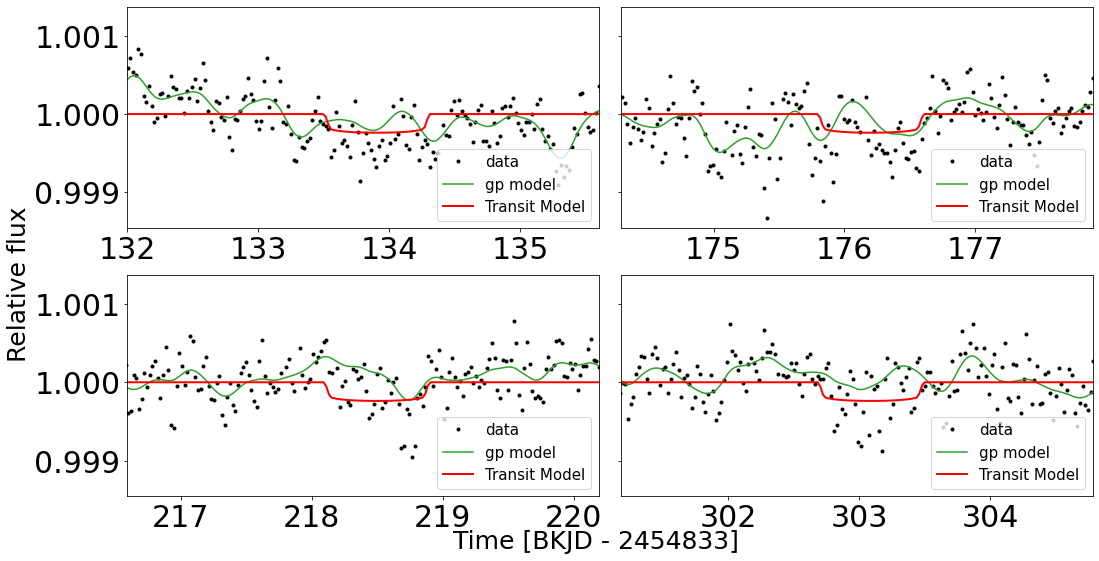

In [9]:
def GaussianChecking(Lower_xlim, Upper_xlim, PlotNumber, figX, figY,mask,extras0,map_soln0,save=True,name=""):
    if mask is None:
        mask = np.ones(len(time_cull), dtype=bool)
    else:
        mask = mask
    cols = int(PlotNumber/2)
    rows = 2
    p = map_soln0["period"][0]# type: ignore 
    t0 = map_soln0["t0"][0] # type: ignore 
    Initial_Limits = np.array([Lower_xlim,Upper_xlim]) # reference point for the first transit epoch
    gp_mod = extras0["gp_pred"] + map_soln0["mean"] # type: ignore

    fig, axes = plt.subplots(cols,rows, figsize=(figX,figY), sharex=False, sharey=True)
    for index in range(PlotNumber):
        col = index // rows
        row = index % rows
        j = index
        if index == 3: # data is chopped too late for this one, skip it
            j += 1 
        ax = axes[col, row]
        ax.plot(time_cull[mask], flux_cull[mask], ".k", label="data")
        ax.plot(time_cull[mask], gp_mod, color="C2", label="gp model")
        ax.plot(
        time_cull[mask],(map_soln0["light_curves"][:,0])[mask]+1,lw=2,label="Transit Model",color="r" # type: ignore
        )
        ax.legend(loc='lower right',fontsize=15)
        ax.set_xlim(Initial_Limits[0] + j *p, Initial_Limits[1] + j *p)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
    fig.text(0.53, 0.04, "Time [BKJD - 2454833]", ha='center', fontsize=25)
    fig.text(-0.015, 0.5, "Relative flux", va='center', rotation='vertical', fontsize=25)

    plt.tight_layout(rect=[0, 0.05, 1, 1]) 
    if save==True:
        fig.savefig(name, facecolor='w',dpi=100,bbox_inches='tight')
    return
GaussianChecking(132,135.6,4,15,8,None,extras0,map_soln0, False,"ASTERO+GP+Transit_2x2.png")

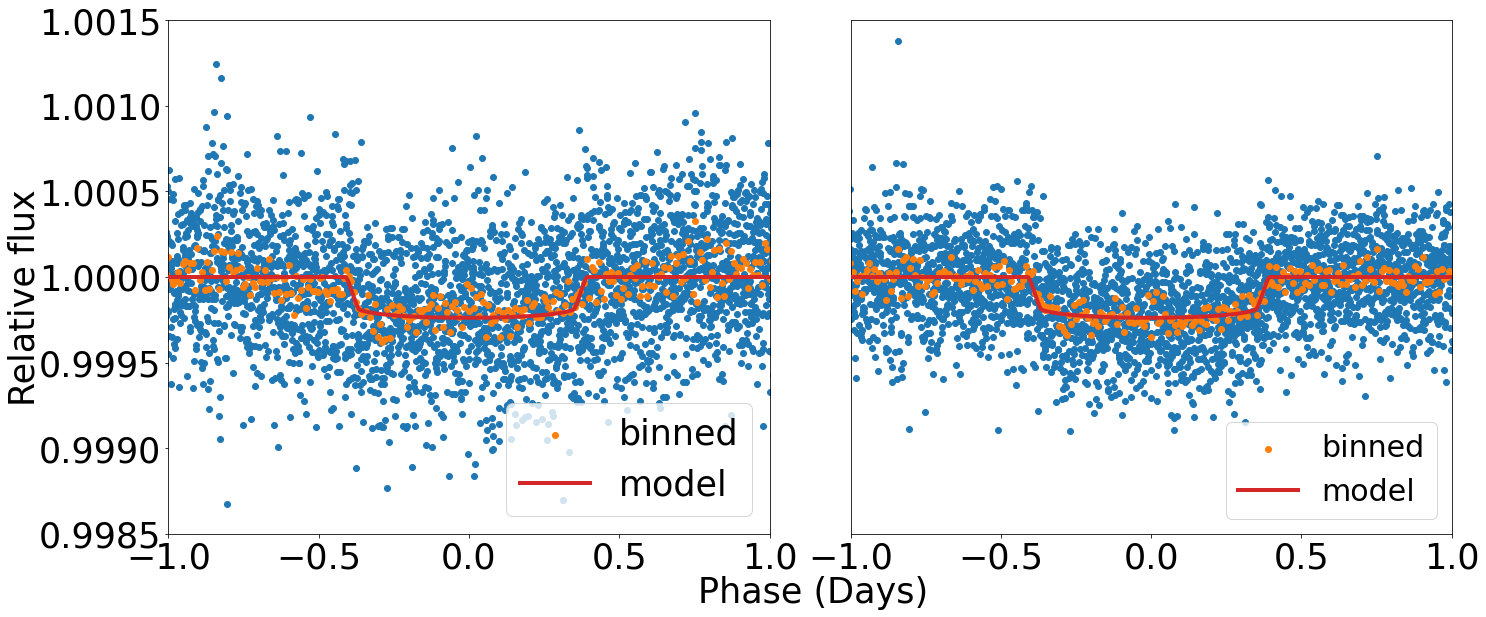

In [10]:
def plot_light_curve(map_soln, extras, mask=None,save=True):
    if mask is None:
        mask = np.ones(len(time_cull), dtype=bool)

    p_map0 = map_soln0["period"][0]# type: ignore 
    t0_map0 = map_soln0["t0"][0] # type: ignore 
    other_map0 =  map_soln0["light_curves"][:,0]# type: ignore
    gp_mod = extras["gp_pred"] + map_soln["mean"]

    figure, axes = plt.subplots(1,2, figsize=(20, 8), sharex=False)
    
    # Plot the folded data
    ax = axes[0]
    x_fold_map0= (time_cull - t0_map0 + 0.5 * p_map0) % p_map0 - 0.5 * p_map0
    ax.scatter(x_fold_map0, flux_cull)
    
    #binned data
    binned = lc.fold(period=p_map0, epoch_time=t0_map0).bin(.008).remove_outliers()
    flux_binned = binned.flux
    time_binned = binned.time.value
    ax.scatter(time_binned,flux_binned, label='binned', zorder=2)
    
    #plotting folded model
    inds = np.argsort(x_fold_map0) #organises the time data in increasing order
    inds = inds[np.abs(x_fold_map0)[inds] < days]
    ax.plot(x_fold_map0[inds], (other_map0+1)[inds], label="model",zorder=1000,color="C3",lw=4)

    ax.legend(loc="lower right",fontsize=35)
    ax.tick_params(axis='both', which='major', labelsize=35)
    ax.set_xlim(-1,1)
    ax.set_ylim(0.9985,1.0015)

    # Plot the folded data
    ax = axes[1]
    gp_scaled = flux_cull-gp_mod
    ax.scatter(x_fold_map0, gp_scaled+1)
    #binned data
    lcgp = lk.LightCurve(time=time_cull, flux=gp_scaled,flux_err=flux_err_cull-gp_mod).fold(period=p_map0, epoch_time=t0_map0).bin(0.008) # type: ignore
    flux_gp = lcgp.flux.value
    time_gp = lcgp.time.value
    ax.scatter(time_gp,flux_gp+1, label='binned', zorder=2)

    #plotting folded model
    inds = np.argsort(x_fold_map0) #organises the time data in increasing order
    inds = inds[np.abs(x_fold_map0)[inds] < days]
    ax.plot(x_fold_map0[inds], (other_map0+1)[inds], label="model",zorder=1000,color="C3",lw=4)
    # ax.set_xlabel('Phase')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xlim(-1,1)
    ax.set_ylim(0.9985,1.0015)
    ax.tick_params(axis='both', which='major', labelsize=35)
    ax.legend(loc="lower right",fontsize=fontsize)
    figure.text(-0.03, 0.5, "Relative flux", va='center', rotation='vertical', fontsize=35)
    figure.text(0.53, -0.03, "Phase (Days)", ha='center', fontsize=35)
    plt.tight_layout()
    if save==True:
        figure.savefig('ASTERO+Transit+GPTransit.png', facecolor='w',bbox_inches='tight')
    return fig

p_map0 = map_soln0["period"][0]# type: ignore 
t0_map0 = map_soln0["t0"][0] # type: ignore 
other_map0 =  map_soln0["light_curves"][:,0]# type: ignore
_ = plot_light_curve(map_soln0, extras0,save=True)

Checking Transit + RV Models

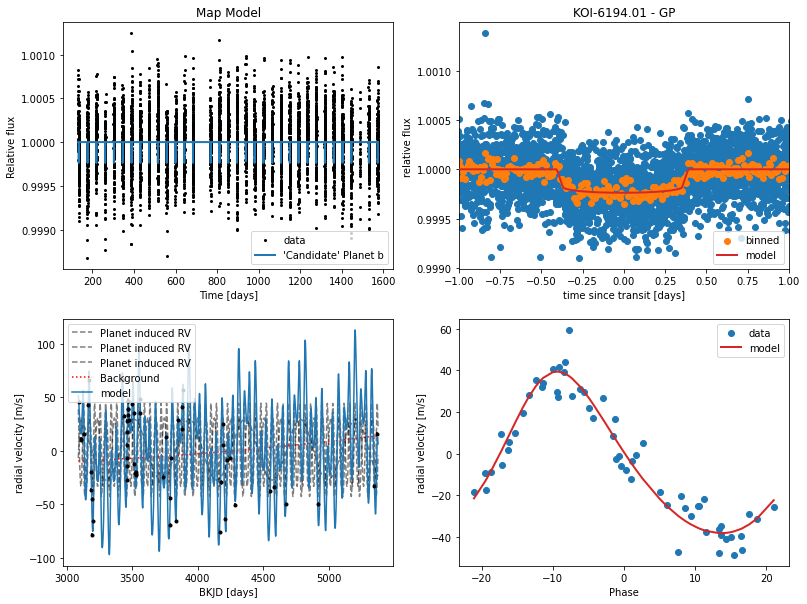

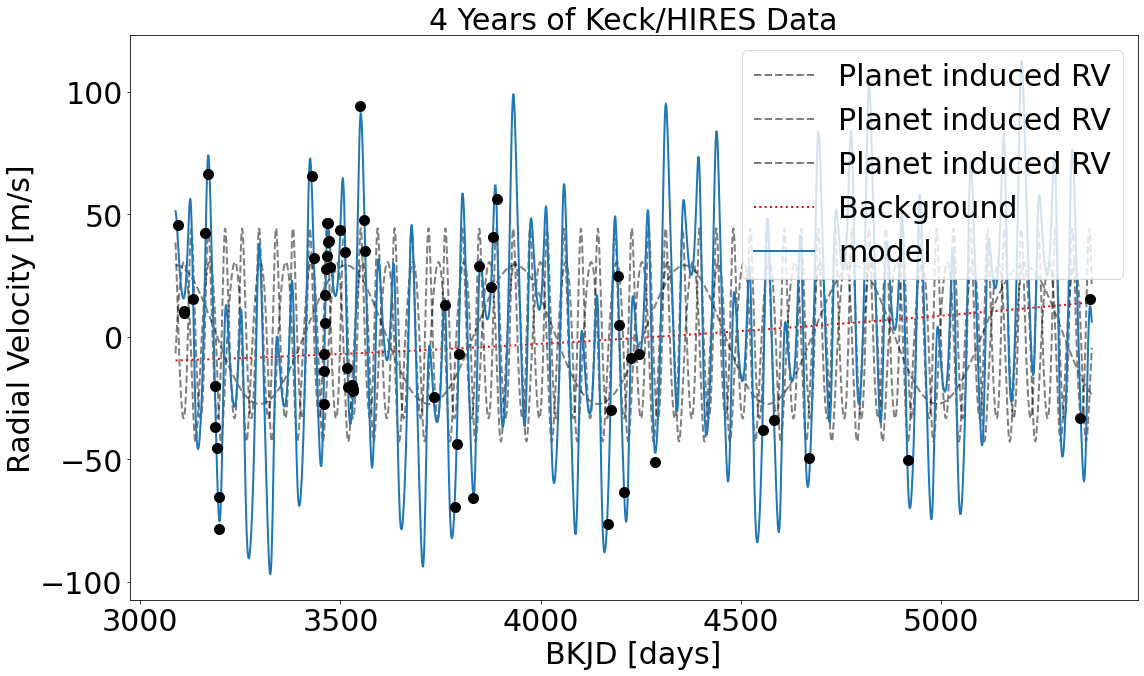

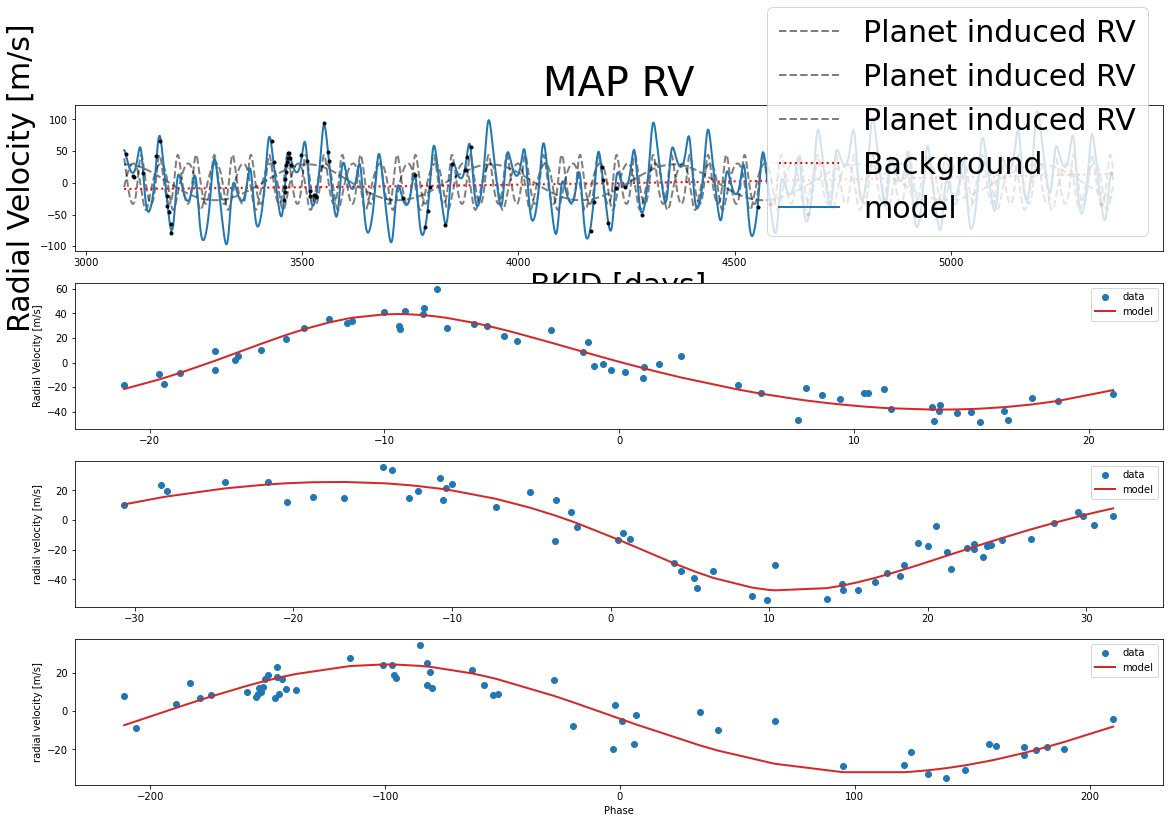

In [11]:
def MAPFitting(map_soln,extras,mask):
    if mask is None:
        mask = np.ones(len(time_cull), dtype=bool)

    #plotting simulated data against maximum posteriori model
    fig, axes = plt.subplots(2,2,figsize=(13, 10),sharey=False, sharex=False)
    p = map_soln["period"]# type: ignore 
    t0 = map_soln["t0"] # type: ignore 

    ax = axes[0,0]
    ax.plot(time_cull,flux_cull,".k",ms=4,label="data")
    ax.plot(
        time_cull,map_soln["light_curves"][:,0]+1,lw=2,label="'Candidate' Planet b", # type: ignore
    )
    ax.set_xlabel("Time [days]")
    ax.legend(fontsize=10)
    _ = ax.set_title("Map Model")
    ax.set_ylabel("Relative flux")

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other =  map_soln["light_curves"][:,0]# type: ignore

    # Plot the folded data
    ax = axes[0,1]
    gp_mod = extras["gp_pred"] + map_soln["mean"] # type: ignore
    gp_scaled = flux_cull[mask]-gp_mod[mask]

    x_fold= (time_cull - t0[0] + 0.5 * p[0]) % p[0] - 0.5 * p[0]
    ax.scatter(x_fold, gp_scaled + 1)
    #binned data
    lcgp = lk.LightCurve(time=time_cull,
                          flux=gp_scaled,
                          flux_err=flux_err_cull-gp_mod).fold(period=p[0], # type: ignore
                                                               epoch_time=t0[0]).bin(0.008).remove_outliers() # type: ignore
    flux_binned = lcgp.flux
    time_binned = lcgp.time.value
    flux_err_binned = lcgp.flux_err
    ax.scatter(time_binned,flux_binned+1, label='binned', zorder=2)
    #plotting folded model
    inds = np.argsort(x_fold) #organises the time data in increasing order
    inds = inds[np.abs(x_fold)[inds] < 2]
    ax.plot(x_fold[inds], (other+1)[inds], label="model",zorder=1000,color="C3",lw=2)

    ax.legend(fontsize=10, loc=4)
    ax.set_xlabel("time since transit [days]")
    ax.set_ylabel("relative flux")
    ax.set_title("KOI-6194.01 - GP")
    _ = ax.set_xlim(-1, 1)

    #plotting RV model
    ax = axes[1,0]
    ax.errorbar(t_BKJD, rv, yerr=rv_err, fmt=".k")
    ax.plot(t_rv, map_soln["vrad_pred"], "--k", label="Planet induced RV",alpha=0.5) # type: ignore # RV induced by planets 
    ax.plot(t_rv, map_soln["bkg_pred"], ":r", label="Background")  # type: ignore # RV induced by background sources
    ax.plot(t_rv, map_soln["rv_model_pred"], label="model") # type: ignore
    ax.legend(fontsize=10)
    _ = ax.set_xlabel("BKJD [days]")
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1,1]
    other1 =  map_soln["vrad"][:,0]# type: ignore

    # Plot the folded data
    x_fold1= (t_BKJD - t0[0] + 0.5 * p[0]) % p[0] - 0.5 * p[0] # type: ignore
    ax.scatter(x_fold1, rv-(map_soln["vrad"][:,1]+map_soln["vrad"][:,2]),label="data") # type: ignore
    inds = np.argsort(x_fold1) #organises the time data in increasing order
    #plotting folded model
    ax.plot(x_fold1[inds], other1[inds]-map_soln["mean_rv"], label="model",zorder=1000,color="C3",lw=2) # type: ignore
    ax.legend()
    ax.set_ylabel('radial velocity [m/s]')
    _ = ax.set_xlabel('Phase')
    fig.savefig('ASTERO+MAP TransitRV.png', facecolor='w')
    # plt.close()

    #plotting the RVs only
    fig_RV, axes = plt.subplots(1,figsize=(16, 10))
    ax_rv = axes
    ax_rv.scatter(t_BKJD, rv, s=100,c='k',zorder=100)
    ax_rv.plot(t_rv, map_soln["vrad_pred"], "--k", label="Planet induced RV",alpha=0.5,linewidth=2.0) # type: ignore # RV induced by planets 
    ax_rv.plot(t_rv, map_soln["bkg_pred"], ":r", label="Background",linewidth=2.0)  # type: ignore # RV induced by background sources
    ax_rv.plot(t_rv, map_soln["rv_model_pred"], label="model",linewidth=2.0) # type: ignore
    ax_rv.legend(fontsize=fontsize, loc='upper right')
    ax_rv.set_xlabel("BKJD [days]",fontsize=fontsize)
    ax_rv.set_ylabel("Radial Velocity [m/s]",fontsize=fontsize)
    ax_rv.set_title("4 Years of Keck/HIRES Data",fontsize=fontsize)
    ax_rv.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the xlabel
    fig_RV.savefig('MAP_RV.png',dpi=100, facecolor='w',bbox_inches='tight')

    #RV model and plots
    fig, axes = plt.subplots(4,1,figsize=(16, 12),sharey=False, sharex=False)
    ax = axes[0]
    ax.errorbar(t_BKJD, rv, yerr=rv_err, fmt=".k")
    ax.plot(t_rv, map_soln["vrad_pred"], "--k", label="Planet induced RV",alpha=0.5,linewidth=2.0) # type: ignore # RV induced by planets 
    ax.plot(t_rv, map_soln["bkg_pred"], ":r", label="Background",linewidth=2.0)  # type: ignore # RV induced by background sources
    ax.plot(t_rv, map_soln["rv_model_pred"], label="model",linewidth=2.0) # type: ignore
    ax.legend(fontsize=fontsize, loc='lower right')
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the xlabel
    ax.set_xlabel("BKJD [days]",fontsize=fontsize)
    ax.set_ylabel("Radial Velocity [m/s]",fontsize=fontsize)
    ax.set_title("MAP RV",fontsize=titlesize)

    other1 =  map_soln["vrad"][:,0]# type: ignore
    ax = axes[1]
    # Plot the folded data
    x_fold1= (t_BKJD - t0[0] + 0.5 * p[0]) % p[0] - 0.5 * p[0] # type: ignore
    ax.scatter(x_fold1, rv-(map_soln["vrad"][:,1]+map_soln["vrad"][:,2]),label="data") # type: ignore
    inds = np.argsort(x_fold1) #organises the time data in increasing order
    #plotting folded model
    ax.plot(x_fold1[inds], other1[inds]-map_soln["mean_rv"], label="model",zorder=1000,color="C3",lw=2) # type: ignore
    ax.legend()
    ax.set_ylabel('Radial Velocity [m/s]')

    ax = axes[2]
    other2 =  map_soln["vrad"][:,1]# type: ignore
    # Plot the folded data
    x_fold2= (t_BKJD - t0[1] + 0.5 * p[1]) % p[1] - 0.5 * p[1] # type: ignore
    ax.scatter(x_fold2, rv-(map_soln["vrad"][:,0]+map_soln["vrad"][:,2]),label="data") # type: ignore
    inds = np.argsort(x_fold2) #organises the time data in increasing order
    #plotting folded model
    ax.plot(x_fold2[inds], other2[inds]-map_soln["mean_rv"], label="model",zorder=1000,color="C3",lw=2) # type: ignore
    ax.legend()
    ax.set_ylabel('radial velocity [m/s]')

    ax = axes[3]
    other3 =  map_soln["vrad"][:,2]# type: ignore
    # Plot the folded data
    x_fold3= (t_BKJD - t0[2] + 0.5 * p[2]) % p[2] - 0.5 * p[2] # type: ignore
    ax.scatter(x_fold3, rv-(map_soln["vrad"][:,1]+map_soln["vrad"][:,0]),label="data") # type: ignore
    inds = np.argsort(x_fold3) #organises the time data in increasing order
    #plotting folded model
    ax.plot(x_fold3[inds], other3[inds]-map_soln["mean_rv"], label="model",zorder=1000,color="C3",lw=2) # type: ignore
    ax.legend()
    ax.set_ylabel('radial velocity [m/s]')
    ax.set_xlabel('Phase')
    fig.savefig('ASTERO+MAP RV.png', facecolor='w')
    return 
MAPFitting(map_soln0,extras0,None)

Sigma Clipping

In [12]:
Sigma = 6
mod_1 = (extras0["gp_pred"]+ map_soln0["mean"]+ np.sum(extras0["light_curves"], axis=-1)) # type: ignore
resid_1 = flux_cull - mod_1
rms_1 = np.sqrt(np.median(resid_1**2))
mask_1 = np.abs(resid_1) < Sigma * rms_1

Rebuilding Model

In [13]:
model, map_soln, extras, orbit = build_model(mask_1, map_soln0)

mean                      -3.220000e+00
t0                         2.487000e+01
log_period                 2.487000e+01
log_m_pl                  -4.840000e+00
u_quadlimbdark__          -2.820000e+00
m_star                     2.160000e+00
rho_star                   9.850000e+00
b_interval__              -4.160000e+00
r_pl_interval__           -6.120000e+00
ecs_unitdisk+interval__   -4.160000e+00
jitter                    -9.200000e-01
trend                      4.150000e+00
log_sigma_lc              -3.220000e+00
log_rho_gp                -3.220000e+00
log_sigma_gp              -3.220000e+00
log_jitter                -1.610000e+00
means                     -6.220000e+00
gp                        -1.438398e+09
obs_lc                    -4.843985e+04
obs_rv                    -3.086900e+02
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_jitter, log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -1438446917.8129249 -> -7610.0306223106245
optimizing logp for variables: [log_m_pl, b, log_period, t0, r_pl]


message: Desired error not necessarily achieved due to precision loss.
logp: -7610.030622310748 -> 4243.229607781872
optimizing logp for variables: [jitter, means, ecs, log_m_pl]


message: Desired error not necessarily achieved due to precision loss.
logp: 4243.229607781872 -> 4331.235611745729
optimizing logp for variables: [means, log_jitter, log_sigma_gp, log_rho_gp, log_sigma_lc, trend, jitter, ecs, r_pl, b, rho_star, m_star, u, log_m_pl, log_period, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 4331.235611745729 -> 4633.121282917791


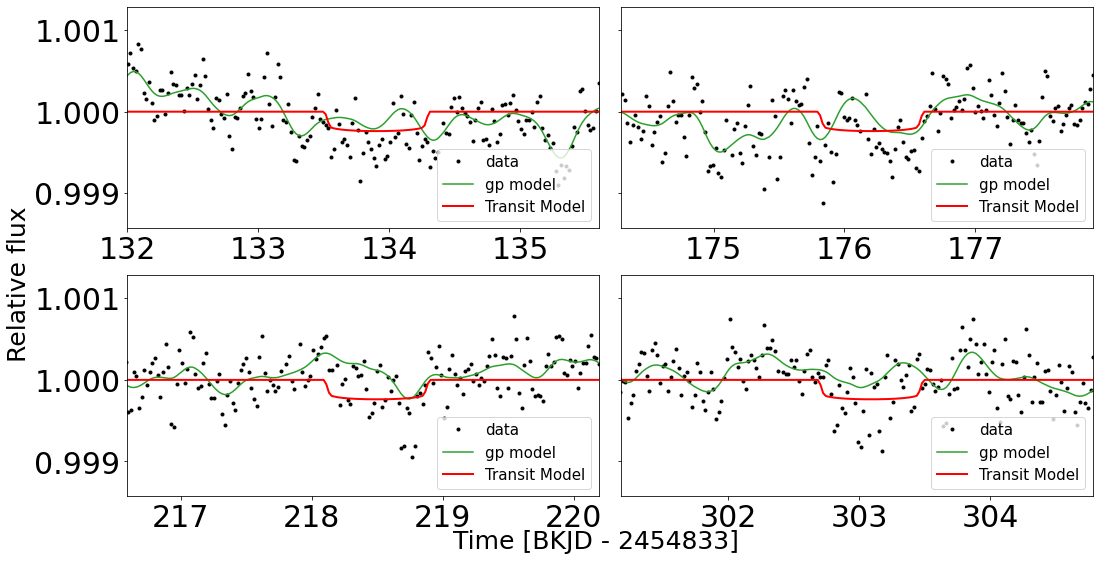

In [14]:
GaussianChecking(132,135.6,4,15,8,mask_1,extras,map_soln,True,"ASTERO+SigmaGaussianFitting_2x2.png")

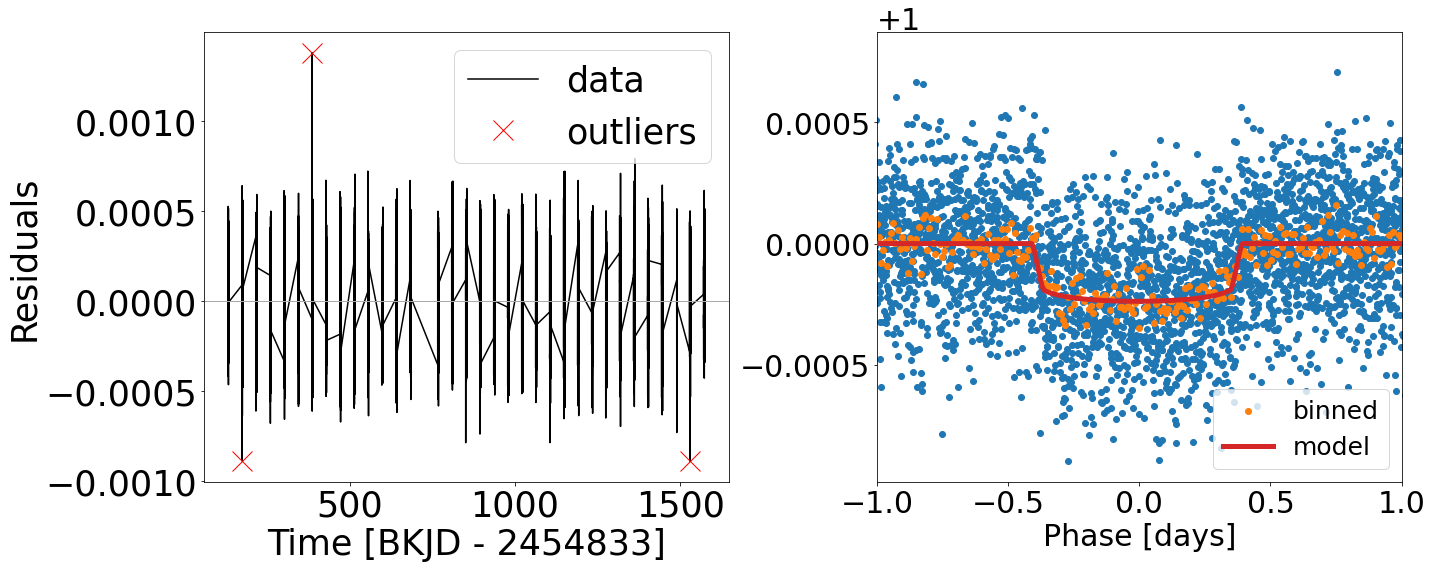

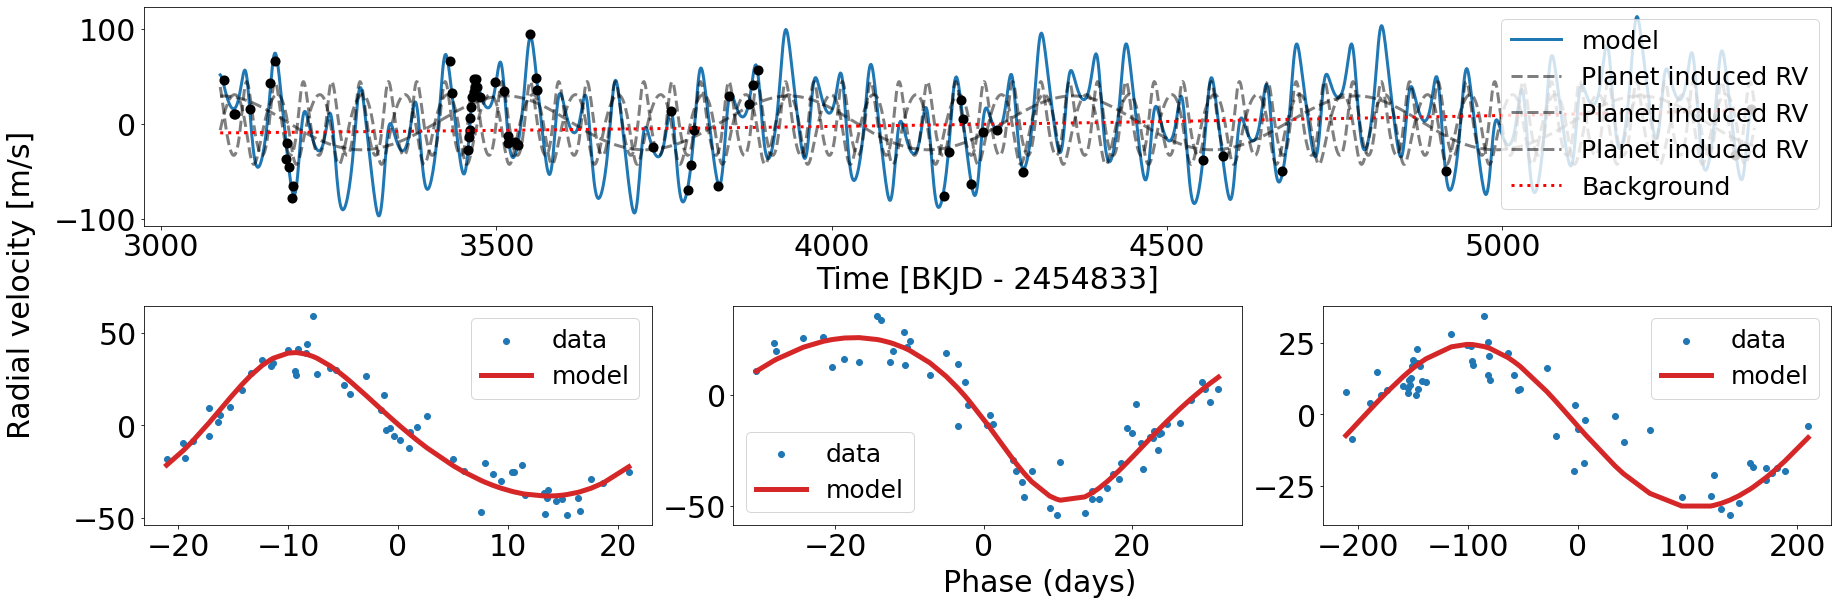

In [15]:
# MAPFitting(map_soln,extras,mask_1)
mask = np.ones(len(time_cull), dtype=bool)
p = map_soln["period"]# type: ignore 
t0 = map_soln["t0"] # type: ignore 

#plotting simulated data against maximum posteriori model
fontsize = 30
legendsize=25
titlesize=20

# Compute the median of posterior estimate of the contribution from
# the other planet. Then we can remove this from the data to plot
# just the planet we care about.
other =  map_soln["light_curves"][:,0]# type: ignore

# this is only for plotting the gp-scaled transit model prior to sigma clipping

fig, axes = plt.subplots(1,2, figsize=(20,8)) # type: ignore

#plotting sigma clipping
ax = axes[0]
ax.plot(time_cull, resid_1, "k", label="data")
ax.plot(time_cull[~mask_1], resid_1[~mask_1], "xr", label="outliers", markersize=20)
ax.axhline(0, color="#aaaaaa", lw=1)
ax.set_ylabel("Residuals",fontsize=35)
ax.set_xlabel("Time [BKJD - 2454833]",fontsize=35)
ax.tick_params(axis='both',which='major',labelsize=35)
ax.legend(loc='upper right',fontsize=35)

# Plot the folded data
ax = axes[1]
gp_mod = extras["gp_pred"] + map_soln["mean"] # type: ignore
gp_scaled = flux_cull[mask_1]-gp_mod

x_fold= (time_cull - t0[0] + 0.5 * p[0]) % p[0] - 0.5 * p[0]
ax.scatter(x_fold[mask_1], gp_scaled + 1)
#binned data
lcgp = lk.LightCurve(time=time_cull[mask_1], flux=gp_scaled).fold(period=p[0], epoch_time=t0[0]).bin(0.008).remove_outliers() # type: ignore
time_binned = lcgp.time.value
flux_binned = lcgp.flux.value
flux_err_binned = lcgp.flux_err
ax.scatter(time_binned,flux_binned + 1, label='binned', zorder=2)

#plotting folded model
inds = np.argsort(x_fold) #organises the time data in increasing order
inds = inds[np.abs(x_fold)[inds] < 2]
ax.plot(x_fold[inds], (other)[inds] + 1, label="model",zorder=1000,color="C3",lw=5)
ax.legend(fontsize=legendsize, loc=4)
ax.tick_params(axis='both',which='major',labelsize=fontsize)
ax.yaxis.get_offset_text().set_fontsize(fontsize)
ax.set_xlabel("Phase [days]",fontsize=fontsize)
ax.set_xlim(-1, 1)

plt.tight_layout()
fig.savefig('ASTERO+Sigma MAP TransitRV.png', facecolor='w',dpi=100,bbox_inches='tight')

#plotting the RVs only
fig, axes = plt.subplots(2,3,figsize=(25, 8),sharey=False, sharex=False)
axes[0, 0].remove()  
axes[0, 1].remove()
axes[0, 2].remove()

ax = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax.plot(t_rv, map_soln["rv_model_pred"],linewidth=3.0, label="model",zorder=-10) # type: ignore
ax.scatter(t_BKJD, rv,s=50,c="k",linewidth=3.0,zorder=1)
ax.plot(t_rv, map_soln["vrad_pred"], "--k",linewidth=3.0, label="Planet induced RV",alpha=0.5) # type: ignore # RV induced by planets 
ax.plot(t_rv, map_soln["bkg_pred"], ":r",linewidth=3.0, label="Background")  # type: ignore # RV induced by background sources
ax.legend(fontsize=legendsize, loc='upper right')
ax.set_xlabel("Time [BKJD - 2454833]",fontsize=fontsize)
other1 =  map_soln["vrad"][:,0]# type: ignore
ax.tick_params(axis='both',which='major',labelsize=fontsize)

ax = axes[1,0]
# Plot the folded data
x_fold1= (t_BKJD - t0[0] + 0.5 * p[0]) % p[0] - 0.5 * p[0] # type: ignore
ax.scatter(x_fold1, rv-(map_soln["vrad"][:,1]+map_soln["vrad"][:,2]),label="data") # type: ignore
inds = np.argsort(x_fold1) #organises the time data in increasing order
#plotting folded model
ax.plot(x_fold1[inds], other1[inds]-map_soln["mean_rv"], label="model",zorder=1000,color="C3",lw=5) # type: ignore
ax.tick_params(axis='both',which='major',labelsize=fontsize)
ax.legend(fontsize=legendsize)

ax = axes[1,1]
other2 =  map_soln["vrad"][:,1]# type: ignore
# Plot the folded data
x_fold2= (t_BKJD - t0[1] + 0.5 * p[1]) % p[1] - 0.5 * p[1] # type: ignore
ax.scatter(x_fold2, rv-(map_soln["vrad"][:,0]+map_soln["vrad"][:,2]),label="data") # type: ignore
inds = np.argsort(x_fold2) #organises the time data in increasing order

#plotting folded model
ax.plot(x_fold2[inds], other2[inds]-map_soln["mean_rv"], label="model",zorder=1000,color="C3",lw=5) # type: ignore
ax.tick_params(axis='both',which='major',labelsize=fontsize)
# ax.set_title("KOI-6194c Phase Folded RV",fontsize=titlesize)
ax.legend(fontsize=legendsize)

ax = axes[1,2]
other3 =  map_soln["vrad"][:,2]# type: ignore
# Plot the folded data
x_fold3= (t_BKJD - t0[2] + 0.5 * p[2]) % p[2] - 0.5 * p[2] # type: ignore
ax.scatter(x_fold3, rv-(map_soln["vrad"][:,1]+map_soln["vrad"][:,0]),label="data") # type: ignore
inds = np.argsort(x_fold3) #organises the time data in increasing order
#plotting folded model
ax.plot(x_fold3[inds], other3[inds]-map_soln["mean_rv"], label="model",zorder=1000,color="C3",lw=5) # type: ignore
# ax.set_xlabel('Phase (days)',fontsize=titlesize)
ax.tick_params(axis='both',which='major',labelsize=fontsize)
ax.legend(fontsize=legendsize)
fig.text(-0.02, 0.5, "Radial velocity [m/s]", va='center', rotation='vertical', fontsize=fontsize)
fig.text(0.5, -0.02, "Phase (days)", va='center', rotation='horizontal', fontsize=fontsize)
plt.tight_layout()
fig.savefig('ASTERO+Sigma MAP RV.png', facecolor='w',dpi=100,bbox_inches='tight')

In [18]:
import multiprocessing

with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        initvals=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],
        mp_ctx=multiprocessing.get_context("fork"),
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/justv/anaconda3/envs/exoplanet_lightkurve/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [means, log_jitter, log_sigma_gp, log_rho_gp, log_sigma_lc, trend, jitter, ecs, r_pl, b, rho_star, m_star, u, log_m_pl, log_period, t0, mean]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 1053 seconds.


In [20]:
import arviz as az, numpy as np, matplotlib.pyplot as plt
import pickle

# #saves trace
# with open('ASTERO+TRANSIT+RV+GP MODEL_Adj.pkl', 'wb') as buff:
#     pickle.dump({'model': model, 'trace': trace}, buff)
# loads trace
with open('ASTERO+TRANSIT+RV+GP MODEL_Adj.pkl', 'rb') as buff:
    data = pickle.load(buff)  


In [21]:
model, trace = data['model'], data['trace']

summ = az.summary(
    trace,
    var_names=["trend", "r_star","m_star","t0", "a","period","r_pl","ror","b","m_pl","jitter","ecc","omega","log_sigma_gp","log_rho_gp"] 
)
# summ.to_csv('Summary.csv')

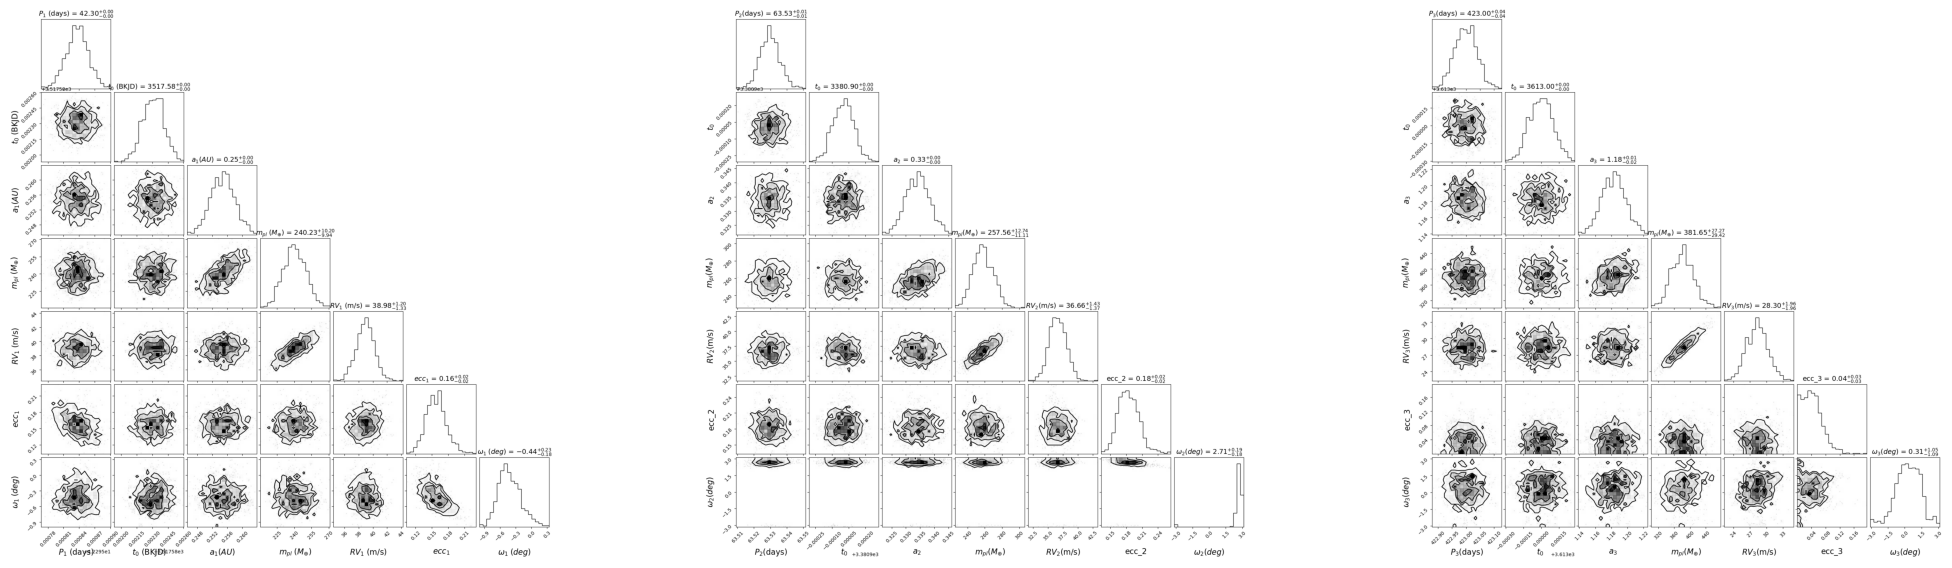

In [22]:
import corner
from PIL import Image
# Getting traces for the corner plot to circumvent plotting uninformative posteriors 
# only taking the first chain!!
fig, axes = plt.subplots(1,3,figsize=(30,8))
i = 0
while i < 3:
    m_star_trace = trace.posterior["m_star"][0] 
    r_star_trace = trace.posterior["r_star"][0] 
    ror_trace = trace.posterior["ror"].values[:,:,0][0] 
    b_trace = trace.posterior["b"].values[:,:,0][0] 
    r_pl_trace = trace.posterior["r_pl"].values[:,:,0][0]/10 
    period_trace = trace.posterior["period"].values[:, :, i][0] # posterior period # type: ignore
    t0_trace = trace.posterior["t0"].values[:, :, i][0] # posterior period # type: ignore
    a_trace = (trace.posterior["a"].values[:,:,i][0] * 696000) / (1.495979e+8)
    m_pl_trace = trace.posterior["m_pl"].values[:,:,i][0]
    ecc_trace = trace.posterior["ecc"].values[:,:,i][0] 
    omega_trace = trace.posterior["omega"].values[:,:,i][0] 
    rv_trace =203* (m_pl_trace/317)/(period_trace**(1/3)*(m_star_trace+(9.548E-4)*m_pl_trace/317)**(2/3)*np.sqrt(1-ecc_trace**2)) 

    if i == 0:
        samples = np.vstack([period_trace,t0_trace,a_trace,m_pl_trace,rv_trace,ecc_trace,omega_trace])#,m_star_trace,r_star_trace b_trace,r_pl_trace,ror_trace,"b","$r_{pl} \; (R_{\oplus})$","ror",
        sample_labels = np.array(["$P_{0}$ (days)".format(i+1),"$t_0$ (BKJD)","$a_{0} (AU)$".format(i+1),"$m_{0} \; (M_{1})$".format('{pl}','{\oplus}'),
                                  "$RV_{0}$ (m/s)".format(i+1),"$ecc_{0}$".format(i+1),"$\omega_{0} \; (deg)$".format(i+1)])#,"$M_* \; (M_{\odot})$","$R_* \; (R_{\odot})$"
        samples_star = np.vstack([m_star_trace,r_star_trace, b_trace,r_pl_trace,ror_trace])#
        sample_star_labels = np.array(["$M_*(M_{\odot})$","$R_*(R_{\odot})$",
                                       "b","$r_{pl}(R_{\oplus})$","ror",])#,
        figure_star = corner.corner(samples_star.T,labels=sample_star_labels,show_titles=True,filter_vars='regex',label_kwargs=dict(fontsize=16),title_kwargs=dict(fontsize=16))
        figure_star.savefig('corner_star.png',dpi=100, facecolor='w',bbox_inches='tight')
        plt.close(figure_star)
    else:
        samples = np.vstack([period_trace,t0_trace,a_trace,m_pl_trace,rv_trace,ecc_trace,omega_trace])
        sample_labels = np.array(["$P_{0}$(days)".format(i+1),"$t_0$","$a_{0}$".format(i+1),"$m_{0}(M_{1})$".format('{pl}','{\oplus}'),
                                  "$RV_{0}$(m/s)".format(i+1),"ecc_{0}".format(i+1),"$\omega_{0}(deg)$".format(i+1)])
    figure = corner.corner(samples.T,labels=sample_labels,show_titles=True,filter_vars='regex',label_kwargs=dict(fontsize=16),title_kwargs=dict(fontsize=14))
    figure.savefig('corner_{0}.png'.format(i+1),dpi=100, facecolor='w',bbox_inches='tight')
    
    plt.close(figure)
    
    img = Image.open("corner_{0}.png".format(i+1))
    axes[i].imshow(img)
    axes[i].axis('off')
    i += 1

plt.tight_layout()
# plt.savefig('Combined_corner.png',dpi=100, facecolor='w',bbox_inches='tight')


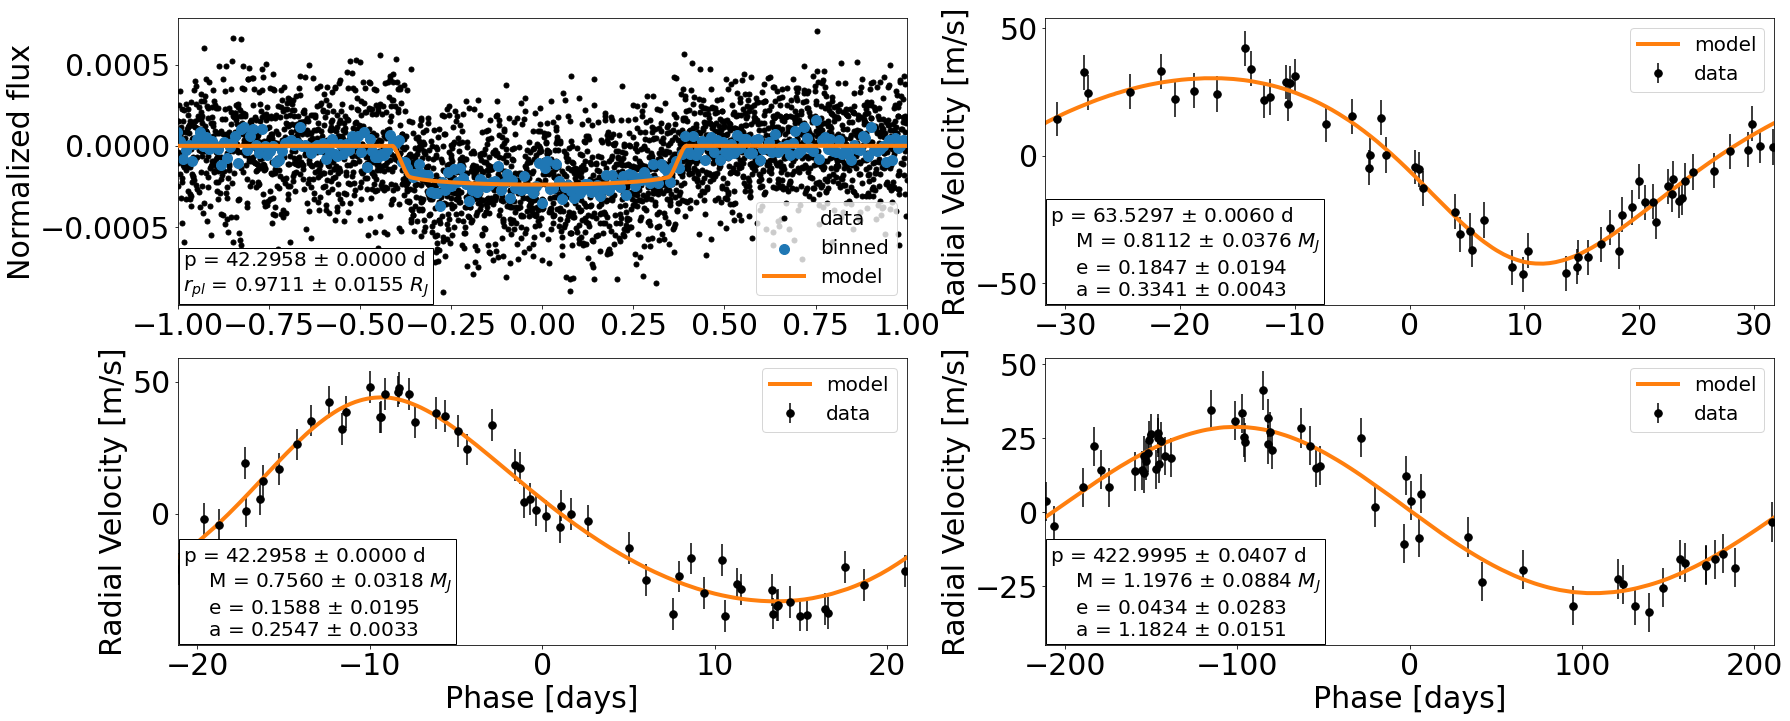

In [53]:
fig, axes = plt.subplots(2,2, figsize=(25,10), sharex=False, sharey=False) #,gridspec_kw={'hspace': 0.25}
thickness = 4
period_trace = trace.posterior["period"].values[:, :, 0] # posterior period # type: ignore
ror_trace = trace.posterior["ror"].values[:,:,0] # posterior radius ratio # type: ignore
r_pl_trace = trace.posterior["r_pl"].values[:,:,0]/10 # posterior r_pl # type: ignore

p=np.mean(period_trace)
t0=np.mean(trace.posterior["t0"].values[:, :, 0]) # type: ignore
lcs = trace.posterior["light_curves"].values # type: ignore
other = np.median(lcs[:, :, :, 0], axis=(0, 1))
gp_mod = extras["gp_pred"] + map_soln["mean"]
flat_samps = trace.posterior.stack(sample=("chain", "draw")) # type: ignore

ax = axes[0,0]
# Plot the folded data
x_fold= (time_cull[mask_1] - t0 + 0.5 * p) % p- 0.5 * p
m = np.abs(x_fold) < 1.0
ax.plot(
    x_fold[m], (flux_cull[mask_1]-gp_mod)[m],".k", markersize=10,label="data", zorder=-1000
)

# Overplot the phase binned light curve
lcgp = lk.LightCurve(time=time_cull[mask_1], flux=gp_scaled).fold(period=p, epoch_time=t0).bin(0.008).remove_outliers() # type: ignore
flux_binned = lcgp.flux
time_binned = lcgp.time.value
flux_err_binned = lcgp.flux_err
ax.scatter(time_binned,flux_binned, zorder=2, s=100,label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 10]
pred = np.percentile(flat_samps["lc_pred"][:,0,:], [16, 50, 84], axis=-1)
ax.plot(x_fold[inds], (pred[1][mask_1])[inds], c="C1", label="model",lw=thickness,zorder=1000)

# Annotate the plot with the planet's period
txt_1 = "p = {0:.4f} $\pm$ {1:.4f} d".format(
    np.mean(period_trace), np.std(period_trace)
)
# Annotate the plot with ror
txt_2 = "ror = {0:.4f} $\pm$ {1:.4f}".format(
    np.mean(ror_trace), np.std(ror_trace)
)
# Annotate the plot with r_pl
txt_3 = "$r_{{pl}}$ = {0:.4f} $\pm$ {1:.4f} $R_J$".format(
    np.mean(r_pl_trace), np.std(r_pl_trace)
)

Transit_text = '''{0}
{1}'''.format(txt_1,txt_3)
Annotate(Transit_text,5,5,20)

ax.legend(fontsize=20, loc=4)
ax.set_ylabel("Normalized flux",fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize) 
ax.set_xlim(-1, 1)

#Plotting RVs
j = 0
for n, letter in enumerate("bcd"):
    vrad_model = []
    period_trace = trace.posterior["period"].values[:, :, n]
    t0_trace = trace.posterior["t0"].values[:, :, n]
    a_trace = trace.posterior["a"].values[:,:,n]

    p = np.mean(period_trace)
    t0 = np.mean(t0_trace)
    ecc_trace = trace.posterior["ecc"].values[:,:,n] # type: ignore
    omega_trace = trace.posterior["omega"].values[:,:,n] # type: ignore
    mass_trace = trace.posterior["m_pl"].values[:,:,n] # posterior mass # type: ignore

    if j > 1:
        j = 1
    ax = axes[(n+1)%2,j]
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(flat_samps["vrad"][:,(n + 1)%3], axis=-1)
    other += np.median(flat_samps["bkg"], axis=-1)
    other0 = np.median(flat_samps["vrad"][:,0], axis=-1)
    other1 = np.median(flat_samps["vrad"][:,1], axis=-1)
    other2 = np.median(flat_samps["vrad"][:,2], axis=-1)
    vrad_model.append(other0) # type: ignore
    vrad_model.append(other1) # type: ignore
    vrad_model.append(other2) # type: ignore

    # Annotate the plot with the planet's period
    txt_p = "p = {0:.4f} $\pm$ {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    # Annotate the RV plot with the mass
    txt_4 = "M = {0:.4f} $\pm$ {1:.4f} $M_J$".format(
        np.mean(mass_trace)/M_J, np.std(mass_trace)/M_J
    )
    # Annotate the RV plot with the Radvial Velocity
    txt_6 = "e = {0:.4f} $\pm$ {1:.4f}".format(
        np.mean(ecc_trace), np.std(ecc_trace)
    )
    # Annotate the RV plot with the Argument of Periasteron
    txt_7 = "a = {0:.4f} $\pm$ {1:.4f}".format(
        np.mean((a_trace * 696000) / (1.495979e+8)), np.std((a_trace* 696000) / (1.495979e+8))
    )

    RV_text = '''{0}
    {1}
    {2}
    {3}'''.format(txt_p,txt_4,txt_6,txt_7)

    # Plot the folded data
    x_fold = (t_BKJD - t0 + 0.5 * p) % p - 0.5 * p
    log_jitter = trace.posterior["jitter"].values[:,n] #type: ignore
    jitter_trace = np.mean(np.exp(log_jitter))
    err = np.sqrt(rv_err**2 + jitter_trace**2)
    ax.errorbar(x_fold, rv - (other + vrad_model[(n-1)%3]), yerr=err, fmt=".k", markersize=15, label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p- 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        flat_samps["vrad_pred"][:,n][inds], [16, 50, 84], axis=-1
    )
    ax.plot(t_fold[inds], pred[1], c="C1", lw=thickness,label="model")
    ax.tick_params(axis='both', which='major', labelsize=fontsize) 
    Annotate(RV_text,5,5,20)
    
    ax.set_xlim(-0.5 * p, 0.5 * p)
    ax.legend(fontsize=20, loc="upper right")
    ax.set_ylabel("Radial Velocity [m/s]",fontsize=fontsize)
    if n == 0:
        ax.set_xlabel("Phase [days]",fontsize=fontsize)
    j+=1
ax.set_xlabel("Phase [days]",fontsize=fontsize)
plt.tight_layout()
fig.savefig('Astero_MCMC TransitRV.png', facecolor='w',dpi=100,bbox_inches='tight')
# plt.close()

In [25]:
from IPython.display import display, Math
import csv
j=0
var_names = ["t0", "period","r_pl","a","ror","b","m_pl","ecc","omega"]
star_names = ["rho_star", "m_star"]

names = []
values = []
up_unc = []
low_unc = []
while j < 3:
    if j == 0 :
        for i in star_names:
            flat_samples = trace.posterior[i].values[:, j]
            mcmc = np.percentile(flat_samples, [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], i)
            names.append(i)
            values.append(mcmc[1])
            up_unc.append(q[1])
            low_unc.append(q[0])
            display(Math(txt))
    
    for i in var_names:
        flat_samples = trace.posterior[i].values[:, :, j]
        mcmc = np.percentile(flat_samples, [16, 50, 84])
        q = np.diff(mcmc)
        if i == var_names[6]:
            txt = "\mathrm{{{3}}}_{4} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], i,j+1)
            names.append(i)
            values.append(mcmc[1])
            up_unc.append(q[1])
            low_unc.append(q[0])
        elif i == var_names[3]:
            txt = "\mathrm{{{3}}}_{4} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
            txt = txt.format(((mcmc[1]* 696000) / (1.495979e+8)), ((q[0]* 696000) / (1.495979e+8)),
                              (q[1]* 696000 / (1.495979e+8)), i,j+1)
            names.append(i)
            values.append(((mcmc[1]* 696000) / (1.495979e+8)))
            up_unc.append((q[1]* 696000 / (1.495979e+8)))
            low_unc.append(((q[0]* 696000) / (1.495979e+8)))
        else:
            txt = "\mathrm{{{3}}}_{4} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
            txt = txt.format(mcmc[1], q[0], q[1], i,j+1)
            names.append(i)
            values.append(mcmc[1])
            up_unc.append(q[1])
            low_unc.append(q[0])
        display(Math(txt))
    j+=1

data = [(names, values, up_unc, low_unc) for names, values, up_unc,low_unc in zip(names,values,up_unc,low_unc)]
filename = "MCMC Results.csv"

with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Name','Value','Up_Unc','Low_Unc'])
    writer.writerows(data)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>